# Configurations

### Import

In [1]:
import os
import joblib

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import holidays
from tqdm import tqdm

import torch
import pytorch_forecasting as pf
from PIL import Image
from torchvision import transforms
from transformers import SwinModel
device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [2]:
# General params
random_state = 0

torch.manual_seed(random_state)
np.random.seed(random_state)

### Read

In [3]:
df_raw = pd.read_csv("../visuelle/train.csv")
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,external_code,season,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.004695,0.073239,0.061972,0.066667,0.046009,0.043192,0.026291,0.019718,0.012207,0.014085,0.010329,0.009390,1,SS17,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,0.005634,0.109859,0.128638,0.135211,0.082629,0.098592,0.063850,0.052582,0.034742,0.138967,0.159624,0.055399,2,SS17,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,0.002817,0.207512,0.177465,0.095775,0.041315,0.030047,0.015023,0.006573,0.010329,0.005634,0.002817,0.001878,3,SS17,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem
3,0.000939,0.044131,0.046948,0.041315,0.028169,0.031925,0.031925,0.023474,0.016901,0.028169,0.020657,0.009390,4,SS17,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00004.png,yellow,acrylic,sleeveless
4,0.006573,0.098592,0.125822,0.120188,0.068545,0.046948,0.043192,0.034742,0.030047,0.029108,0.033803,0.009390,5,SS17,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00005.png,grey,acrylic,hem


### Preprocess

In [4]:
df_prep = df_raw.copy().drop(["external_code", "release_date"], axis=1).rename(columns={i:f"release_{i}" for i in ["day", "week", "month", "year"]}).rename(columns={"image_path":"img_path"})
df_prep = pd.melt(df_prep, id_vars=["season", "category", "release_day", "release_week", "release_month", "release_year", "img_path", "color", "fabric", "extra"], value_vars=[f"{i}" for i in range(12)], var_name="time_idx", value_name="sales")
df_prep["img_path"] = "../visuelle/images/" + df_prep["img_path"]
df_prep["time_idx"] = df_prep["time_idx"].astype(int)

df_prep["-1"] = df_prep.groupby("img_path")["time_idx"].shift(-1).dropna()
assert len(df_prep[df_prep["-1"] - df_prep["time_idx"] > 1]) == 0
df_prep = df_prep.drop("-1", axis=1)
df_prep["sales"] = df_prep["sales"] * np.load("../visuelle/normalization_scale.npy")

import joblib
joblib.dump(df_prep, "df_prep.pkl")
df_prep.head()

,season,category,release_day,release_week,release_month,release_year,img_path,color,fabric,extra,time_idx,sales
0,SS17,long sleeve,0.500000,0.923077,1.0,0.998514,../visuelle/images/PE17/00001.png,yellow,acrylic,hem,0,5.0
1,SS17,long sleeve,0.500000,0.923077,1.0,0.998514,../visuelle/images/PE17/00002.png,brown,acrylic,hem,0,6.0
2,SS17,culottes,0.666667,0.923077,1.0,0.998514,../visuelle/images/PE17/00003.png,blue,scuba crepe,hem,0,3.0
3,SS17,long sleeve,0.666667,0.923077,1.0,0.998514,../visuelle/images/PE17/00004.png,yellow,acrylic,sleeveless,0,1.0
4,SS17,long sleeve,0.666667,0.923077,1.0,0.998514,../visuelle/images/PE17/00005.png,grey,acrylic,hem,0,7.0


# Dataset

In [5]:
df_prep = joblib.load("df_prep.pkl")
df_train = df_prep.copy()

encoder = LabelEncoder()
df_train["img_path"] = encoder.fit_transform(df_train["img_path"]) + 1
df_train

,season,category,release_day,release_week,release_month,release_year,img_path,color,fabric,extra,time_idx,sales
0,SS17,long sleeve,0.500000,0.923077,1.000000,0.998514,2701,yellow,acrylic,hem,0,5.0
1,SS17,long sleeve,0.500000,0.923077,1.000000,0.998514,2702,brown,acrylic,hem,0,6.0
2,SS17,culottes,0.666667,0.923077,1.000000,0.998514,2703,blue,scuba crepe,hem,0,3.0
3,SS17,long sleeve,0.666667,0.923077,1.000000,0.998514,2704,yellow,acrylic,sleeveless,0,1.0
4,SS17,long sleeve,0.666667,0.923077,1.000000,0.998514,2705,grey,acrylic,hem,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
60955,AW19,sheath dress,0.333333,0.826923,0.833333,1.000000,2696,black,scuba crepe,racerback,11,30.0
60956,AW19,kimono dress,0.333333,0.826923,0.833333,1.000000,2697,black,nice,zipper,11,16.0
60957,AW19,medium coat,0.500000,0.826923,0.833333,1.000000,2698,black,foam rubber,sleeve,11,22.0
60958,AW19,kimono dress,0.666667,0.826923,0.833333,1.000000,2699,green,acrylic,hem,11,105.0


In [6]:
max_prediction_length = 3 # a whole year
max_encoder_length = 9

# For training/evaluation splits
training_cutoff = df_train["time_idx"].max() - max_prediction_length # validation on 2020

# Create training set
training_dataset = pf.TimeSeriesDataSet(
    df_train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["img_path"], # static covariates
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_reals = ["img_path", "release_day", "release_week", "release_month", "release_year"],
    static_categoricals = ["season", "category", "color", "fabric", "extra"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=['sales'],
    # target_normalizer=pf.data.GroupNormalizer(
    #     groups=["img_path"], transformation="softplus"
    # ),  # use softplus transformation and normalize by group
    target_normalizer = None,
    # lags={'sales': [7, 30, 365]}, # add lagged values of target variable
    scalers = {"img_path":None},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = pf.TimeSeriesDataSet.from_dataset(training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
                                            df_train, # data from which new dataset will be generated
                                            predict=True, # predict the decoder length on the last entries in the time index
                                            stop_randomization=True)

# create training and validation dataloaders for model
batch_size = 64
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

# print(len(train_dataloader))
# next(iter(train_dataloader))

# Train

In [7]:
"""
Timeseries models share a number of common characteristics. This module implements these in a common base class.
"""
from collections import namedtuple
import copy
from copy import deepcopy
import inspect
import logging
import os
from typing import Any, Callable, Dict, Iterable, List, Literal, Optional, Tuple, Union
import warnings

import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import BasePredictionWriter, LearningRateFinder
from lightning.pytorch.trainer.states import RunningStage
from lightning.pytorch.utilities.parsing import AttributeDict, get_init_args
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.function_base import iterable
import pandas as pd
import pytorch_optimizer
from pytorch_optimizer import Ranger21
import scipy.stats
import torch
import torch.nn as nn
from torch.nn.utils import rnn
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import yaml

from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import EncoderNormalizer, GroupNormalizer, MultiNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import (
    MAE,
    MASE,
    SMAPE,
    DistributionLoss,
    MultiHorizonMetric,
    MultiLoss,
    QuantileLoss,
    convert_torchmetric_to_pytorch_forecasting_metric,
)
from pytorch_forecasting.metrics.base_metrics import Metric
from pytorch_forecasting.models.nn.embeddings import MultiEmbedding
from pytorch_forecasting.utils import (
    InitialParameterRepresenterMixIn,
    OutputMixIn,
    TupleOutputMixIn,
    apply_to_list,
    concat_sequences,
    create_mask,
    get_embedding_size,
    groupby_apply,
    to_list,
)

# todo: compile models


def _torch_cat_na(x: List[torch.Tensor]) -> torch.Tensor:
    """
    Concatenate tensor along ``dim=0`` and add nans along ``dim=1`` if necessary.

    Allows concatenation of tensors where ``dim=1`` are not equal.
    Missing values are filled up with ``nan``.

    Args:
        x (List[torch.Tensor]): list of tensors to concatenate along dimension 0

    Returns:
        torch.Tensor: concatenated tensor
    """
    if x[0].ndim > 1:
        first_lens = [xi.shape[1] for xi in x]
        max_first_len = max(first_lens)
        if max_first_len > min(first_lens):
            x = [
                xi
                if xi.shape[1] == max_first_len
                else torch.cat(
                    [
                        xi,
                        torch.full(
                            (xi.shape[0], max_first_len - xi.shape[1], *xi.shape[2:]), float("nan"), device=xi.device
                        ),
                    ],
                    dim=1,
                )
                for xi in x
            ]

    # check if remaining dimensions are all equal
    if x[0].ndim > 2:
        remaining_dimensions_equal = all([all([xi.size(i) == x[0].size(i) for xi in x]) for i in range(2, x[0].ndim)])
    else:
        remaining_dimensions_equal = True

    # deaggregate
    if remaining_dimensions_equal:
        return torch.cat(x, dim=0)
    else:
        # make list instead but warn
        warnings.warn(
            f"Not all dimensions are equal for tensors shapes. Example tensor {x[0].shape}. "
            "Returning list instead of torch.Tensor.",
            UserWarning,
        )
        return [xii for xi in x for xii in xi]



def _concatenate_output(
    output: List[Dict[str, List[Union[List[torch.Tensor], torch.Tensor, bool, int, str, np.ndarray]]]]
) -> Dict[str, Union[torch.Tensor, np.ndarray, List[Union[torch.Tensor, int, bool, str]]]]:
    """
    Concatenate multiple batches of output dictionary.

    Args:
        output (List[Dict[str, List[Union[List[torch.Tensor], torch.Tensor, bool, int, str, np.ndarray]]]]):
            list of outputs to concatenate. Each entry corresponds to a batch.

    Returns:
        Dict[str, Union[torch.Tensor, np.ndarray, List[Union[torch.Tensor, int, bool, str]]]]:
            concatenated output
    """
    output_cat = {}
    for name in output[0].keys():
        v0 = output[0][name]
        # concatenate simple tensors
        if isinstance(v0, torch.Tensor):
            output_cat[name] = _torch_cat_na([out[name] for out in output])
        # concatenate list of tensors
        elif isinstance(v0, (tuple, list)) and len(v0) > 0:
            output_cat[name] = []
            for target_id in range(len(v0)):
                if isinstance(v0[target_id], torch.Tensor):
                    output_cat[name].append(_torch_cat_na([out[name][target_id] for out in output]))
                else:
                    try:
                        output_cat[name].append(np.concatenate([out[name][target_id] for out in output], axis=0))
                    except ValueError:
                        output_cat[name] = [item for out in output for item in out[name][target_id]]
        # flatten list for everything else
        else:
            try:
                output_cat[name] = np.concatenate([out[name] for out in output], axis=0)
            except ValueError:
                if iterable(output[0][name]):
                    output_cat[name] = [item for out in output for item in out[name]]
                else:
                    output_cat[name] = [out[name] for out in output]

    if isinstance(output[0], OutputMixIn):
        output_cat = output[0].__class__(**output_cat)
    return output_cat



STAGE_STATES = {
    RunningStage.TRAINING: "train",
    RunningStage.VALIDATING: "val",
    RunningStage.TESTING: "test",
    RunningStage.PREDICTING: "predict",
    RunningStage.SANITY_CHECKING: "sanity_check",
}

# return type of predict function
PredictTuple = namedtuple(
    "prediction", ["output", "x", "index", "decoder_lengths", "y"], defaults=(None, None, None, None, None)
)


class Prediction(PredictTuple, OutputMixIn):
    pass



class PredictCallback(BasePredictionWriter):
    """Internally used callback to capture predictions and optionally write them to disk."""

    # see base class predict function for documentation of parameters
    def __init__(
        self,
        mode: Union[str, Tuple[str, str]] = "prediction",
        return_index: bool = False,
        return_decoder_lengths: bool = False,
        return_y: bool = False,
        write_interval: Literal["batch", "epoch", "batch_and_epoch"] = "batch",
        return_x: bool = False,
        mode_kwargs: Dict[str, Any] = None,
        output_dir: Optional[str] = None,
        predict_kwargs: Dict[str, Any] = None,
    ) -> None:
        super().__init__(write_interval=write_interval)
        self.mode = mode
        self.return_decoder_lengths = return_decoder_lengths
        self.return_x = return_x
        self.return_index = return_index
        self.return_y = return_y
        self.mode_kwargs = mode_kwargs if mode_kwargs is not None else {}
        self.predict_kwargs = predict_kwargs if predict_kwargs is not None else {}
        self.output_dir = output_dir
        self._reset_data()

    def _reset_data(self, result: bool = True):
        # reset data objects to save results into
        self._output = []
        self._decode_lengths = []
        self._x_list = []
        self._index = []
        self._y = []
        if result:
            self._result = []

    def on_predict_batch_end(
        self,
        trainer: Trainer,
        pl_module: LightningModule,
        outputs: Any,
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        # extract predictions form output
        x = batch[0]
        out = outputs

        lengths = x["decoder_lengths"]

        nan_mask = create_mask(lengths.max(), lengths)
        if isinstance(self.mode, (tuple, list)):
            if self.mode[0] == "raw":
                out = out[self.mode[1]]
            else:
                raise ValueError(
                    f"If a tuple is specified, the first element must be 'raw' - got {self.mode[0]} instead"
                )
        elif self.mode == "prediction":
            out = pl_module.to_prediction(out, **self.mode_kwargs)
            # mask non-predictions
            if isinstance(out, (list, tuple)):
                out = [
                    o.masked_fill(nan_mask, torch.tensor(float("nan"))) if o.dtype == torch.float else o for o in out
                ]
            elif out.dtype == torch.float:  # only floats can be filled with nans
                out = out.masked_fill(nan_mask, torch.tensor(float("nan")))
        elif self.mode == "quantiles":
            out = pl_module.to_quantiles(out, **self.mode_kwargs)
            # mask non-predictions
            if isinstance(out, (list, tuple)):
                out = [
                    o.masked_fill(nan_mask.unsqueeze(-1), torch.tensor(float("nan"))) if o.dtype == torch.float else o
                    for o in out
                ]
            elif out.dtype == torch.float:
                out = out.masked_fill(nan_mask.unsqueeze(-1), torch.tensor(float("nan")))
        elif self.mode == "raw":
            pass
        else:
            raise ValueError(f"Unknown mode {self.mode} - see docs for valid arguments")

        self._output.append(out)
        out = dict(output=out)
        if self.return_x:
            self._x_list.append(x)
            out["x"] = self._x_list[-1]
        if self.return_index:
            self._index.append(trainer.predict_dataloaders.dataset.x_to_index(x))
            out["index"] = self._index[-1]
        if self.return_decoder_lengths:
            self._decode_lengths.append(lengths)
            out["decoder_lengths"] = self._decode_lengths[-1]
        if self.return_y:
            self._y.append(batch[1])
            out["y"] = self._y[-1]

        if isinstance(out, dict):
            out = Prediction(**out)
        # write to disk
        if self.output_dir is not None:
            super().on_predict_batch_end(trainer, pl_module, out, batch, batch_idx, dataloader_idx)


    def write_on_batch_end(self, trainer, pl_module, prediction, batch_indices, batch, batch_idx, dataloader_idx):
        torch.save(prediction, os.path.join(self.output_dir, f"predictions_{batch_idx}.pt"))
        self._reset_data()


    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        torch.save(predictions, os.path.join(self.output_dir, "predictions.pt"))
        self._reset_data()


    def on_predict_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        output = self._output
        if len(output) > 0:
            # concatenate output (of different batches)
            if isinstance(self.mode, (tuple, list)) or self.mode != "raw":
                if (
                    isinstance(output[0], (tuple, list))
                    and len(output[0]) > 0
                    and isinstance(output[0][0], torch.Tensor)
                ):
                    output = [_torch_cat_na([out[idx] for out in output]) for idx in range(len(output[0]))]
                else:
                    output = _torch_cat_na(output)
            elif self.mode == "raw":
                output = _concatenate_output(output)

            # if len(output) > 0:
            # generate output
            if self.return_x or self.return_index or self.return_decoder_lengths or self.return_y:
                output = dict(output=output)
            if self.return_x:
                output["x"] = _concatenate_output(self._x_list)
            if self.return_index:
                output["index"] = pd.concat(self._index, axis=0, ignore_index=True)
            if self.return_decoder_lengths:
                output["decoder_lengths"] = torch.cat(self._decode_lengths, dim=0)
            if self.return_y:
                y = concat_sequences([yi[0] for yi in self._y])
                if self._y[-1][1] is None:
                    weight = None
                else:
                    weight = concat_sequences([yi[1] for yi in self._y])

                output["y"] = (y, weight)
            if isinstance(output, dict):
                output = Prediction(**output)  # save for later writing or outputting
            self._result = output

            # write to disk
            if self.interval.on_epoch:
                self.write_on_epoch_end(trainer, pl_module, self._output, trainer.predict_loop.epoch_batch_indices)
            self._reset_data(result=False)


    @property
    def result(self) -> Prediction:
        if self.output_dir is None:
            return self._result
        else:
            assert len(self._result) == 0, "Cannot return result if output_dir is set"
            return None



class BaseModel(InitialParameterRepresenterMixIn, LightningModule, TupleOutputMixIn):
    """
    BaseModel from which new timeseries models should inherit from.
    The ``hparams`` of the created object will default to the parameters indicated in :py:meth:`~__init__`.

    The :py:meth:`~BaseModel.forward` method should return a named tuple with at least the entry ``prediction``
    that contains the network's output. See the function's documentation for more details.

    The idea of the base model is that common methods do not have to be re-implemented for every new architecture.
    The class is a [LightningModule](https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html)
    and follows its conventions. However, there are important additions:

        * You need to specify a ``loss`` attribute that stores the function to calculate the
          :py:class:`~pytorch_forecasting.metrics.MultiHorizonLoss` for backpropagation.
        * The :py:meth:`~BaseModel.from_dataset` method can be used to initialize a network using the specifications
          of a dataset. Often, parameters such as the number of features can be easily deduced from the dataset.
          Further, the method will also store how to rescale normalized predictions into the unnormalized prediction
          space. Override it to pass additional arguments to the __init__ method of your network that depend on your
          dataset.
        * The :py:meth:`~BaseModel.transform_output` method rescales the network output using the target normalizer
          from thedataset.
        * The :py:meth:`~BaseModel.step` method takes care of calculating the loss, logging additional metrics defined
          in the ``logging_metrics`` attribute and plots of sample predictions. You can override this method to add
          custom interpretations or pass extra arguments to the networks forward method.
        * The :py:meth:`~BaseModel.on_epoch_end` method can be used to calculate summaries of each epoch such as
          statistics on the encoder length, etc and needs to return the outputs.
        * The :py:meth:`~BaseModel.predict` method makes predictions using a dataloader or dataset. Override it if you
          need to pass additional arguments to ``forward`` by default.

    To implement your own architecture, it is best to
    go throught the :ref:`Using custom data and implementing custom models <new-model-tutorial>` and
    to look at existing ones to understand what might be a good approach.

    Example:

        .. code-block:: python

            class Network(BaseModel):

                def __init__(self, my_first_parameter: int=2, loss=SMAPE()):
                    self.save_hyperparameters()
                    super().__init__(loss=loss)

                def forward(self, x):
                    normalized_prediction = self.module(x)
                    prediction = self.transform_output(prediction=normalized_prediction, target_scale=x["target_scale"])
                    return self.to_network_output(prediction=prediction)

    """

    CHECKPOINT_HYPER_PARAMS_SPECIAL_KEY = "__special_save__"

    def __init__(
        self,
        dataset_parameters: Dict[str, Any] = None,
        log_interval: Union[int, float] = -1,
        log_val_interval: Union[int, float] = None,
        learning_rate: Union[float, List[float]] = 1e-3,
        log_gradient_flow: bool = False,
        loss: Metric = SMAPE(),
        logging_metrics: nn.ModuleList = nn.ModuleList([]),
        reduce_on_plateau_patience: int = 1000,
        reduce_on_plateau_reduction: float = 2.0,
        reduce_on_plateau_min_lr: float = 1e-5,
        weight_decay: float = 0.0,
        optimizer_params: Dict[str, Any] = None,
        monotone_constaints: Dict[str, int] = {},
        output_transformer: Callable = None,
        optimizer="Ranger",
    ):
        """
        BaseModel for timeseries forecasting from which to inherit from

        Args:
            log_interval (Union[int, float], optional): Batches after which predictions are logged. If < 1.0, will log
                multiple entries per batch. Defaults to -1.
            log_val_interval (Union[int, float], optional): batches after which predictions for validation are
                logged. Defaults to None/log_interval.
            learning_rate (float, optional): Learning rate. Defaults to 1e-3.
            log_gradient_flow (bool): If to log gradient flow, this takes time and should be only done to diagnose
                training failures. Defaults to False.
            loss (Metric, optional): metric to optimize, can also be list of metrics. Defaults to SMAPE().
            logging_metrics (nn.ModuleList[MultiHorizonMetric]): list of metrics that are logged during training.
                Defaults to [].
            reduce_on_plateau_patience (int): patience after which learning rate is reduced by a factor of 10. Defaults
                to 1000
            reduce_on_plateau_reduction (float): reduction in learning rate when encountering plateau. Defaults to 2.0.
            reduce_on_plateau_min_lr (float): minimum learning rate for reduce on plateua learning rate scheduler.
                Defaults to 1e-5
            weight_decay (float): weight decay. Defaults to 0.0.
            optimizer_params (Dict[str, Any]): additional parameters for the optimizer. Defaults to {}.
            monotone_constaints (Dict[str, int]): dictionary of monotonicity constraints for continuous decoder
                variables mapping
                position (e.g. ``"0"`` for first position) to constraint (``-1`` for negative and ``+1`` for positive,
                larger numbers add more weight to the constraint vs. the loss but are usually not necessary).
                This constraint significantly slows down training. Defaults to {}.
            output_transformer (Callable): transformer that takes network output and transforms it to prediction space.
                Defaults to None which is equivalent to ``lambda out: out["prediction"]``.
            optimizer (str): Optimizer, "ranger", "sgd", "adam", "adamw" or class name of optimizer in ``torch.optim``
                or ``pytorch_optimizer``.
                Alternatively, a class or function can be passed which takes parameters as first argument and
                a `lr` argument (optionally also `weight_decay`). Defaults to
                `"ranger" <https://pytorch-optimizers.readthedocs.io/en/latest/optimizer_api.html#ranger21>`_.
        """
        super().__init__()
        # update hparams
        frame = inspect.currentframe()
        init_args = get_init_args(frame)
        self.save_hyperparameters(
            {name: val for name, val in init_args.items() if name not in self.hparams and name not in ["self"]}
        )

        # update log interval if not defined
        if self.hparams.log_val_interval is None:
            self.hparams.log_val_interval = self.hparams.log_interval

        if not hasattr(self, "loss"):
            if isinstance(loss, (tuple, list)):
                self.loss = MultiLoss(metrics=[convert_torchmetric_to_pytorch_forecasting_metric(l) for l in loss])
            else:
                self.loss = convert_torchmetric_to_pytorch_forecasting_metric(loss)
        if not hasattr(self, "logging_metrics"):
            self.logging_metrics = nn.ModuleList(
                [convert_torchmetric_to_pytorch_forecasting_metric(l) for l in logging_metrics]
            )
        if not hasattr(self, "output_transformer"):
            self.output_transformer = output_transformer
        if not hasattr(self, "optimizer"):  # callables are removed from hyperparameters, so better to save them
            self.optimizer = self.hparams.optimizer
        if not hasattr(self, "dataset_parameters"):
            self.dataset_parameters = dataset_parameters

        # delete everything from hparams that cannot be serialized with yaml.dump
        # which is particularly important for tensorboard logging
        hparams_to_delete = []
        for k, v in self.hparams.items():
            try:
                yaml.dump(v)
            except:  # noqa
                hparams_to_delete.append(k)
                if not hasattr(self, k):
                    setattr(self, k, v)

        self.hparams_special = getattr(self, "hparams_special", [])
        self.hparams_special.extend(hparams_to_delete)
        for k in hparams_to_delete:
            del self._hparams[k]
            del self._hparams_initial[k]
        # epoch outputs
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.testing_step_outputs = []


    def log(self, *args, **kwargs):
        """See :meth:`lightning.pytorch.core.lightning.LightningModule.log`."""
        # never log for prediction
        if not self.predicting:
            super().log(*args, **kwargs)


    @property
    def predicting(self) -> bool:
        return self.current_stage is None or self.current_stage == "predict"

    @property
    def current_stage(self) -> str:
        """
        Available inside lightning loops.
        :return: current trainer stage. One of ["train", "val", "test", "predict", "sanity_check"]
        """
        return STAGE_STATES.get(self.trainer.state.stage, None)

    @property
    def n_targets(self) -> int:
        """
        Number of targets to forecast.

        Based on loss function.

        Returns:
            int: number of targets
        """
        if isinstance(self.loss, MultiLoss):
            return len(self.loss.metrics)
        else:
            return 1

    def transform_output(
        self,
        prediction: Union[torch.Tensor, List[torch.Tensor]],
        target_scale: Union[torch.Tensor, List[torch.Tensor]],
        loss: Optional[Metric] = None,
    ) -> torch.Tensor:
        """
        Extract prediction from network output and rescale it to real space / de-normalize it.

        Args:
            prediction (Union[torch.Tensor, List[torch.Tensor]]): normalized prediction
            target_scale (Union[torch.Tensor, List[torch.Tensor]]): scale to rescale prediction
            loss (Optional[Metric]): metric to use for transform

        Returns:
            torch.Tensor: rescaled prediction
        """
        if loss is None:
            loss = self.loss
        if isinstance(loss, MultiLoss):
            out = loss.rescale_parameters(
                prediction,
                target_scale=target_scale,
                encoder=self.output_transformer.normalizers,  # need to use normalizer per encoder
            )
        else:
            out = loss.rescale_parameters(prediction, target_scale=target_scale, encoder=self.output_transformer)
        return out


    @staticmethod
    def deduce_default_output_parameters(
        dataset: TimeSeriesDataSet, kwargs: Dict[str, Any], default_loss: MultiHorizonMetric = None
    ) -> Dict[str, Any]:
        """
        Deduce default parameters for output for `from_dataset()` method.

        Determines ``output_size`` and ``loss`` parameters.

        Args:
            dataset (TimeSeriesDataSet): timeseries dataset
            kwargs (Dict[str, Any]): current hyperparameters
            default_loss (MultiHorizonMetric, optional): default loss function.
                Defaults to :py:class:`~pytorch_forecasting.metrics.MAE`.

        Returns:
            Dict[str, Any]: dictionary with ``output_size`` and ``loss``.
        """

        # infer output size
        def get_output_size(normalizer, loss):
            if isinstance(loss, QuantileLoss):
                return len(loss.quantiles)
            elif isinstance(normalizer, NaNLabelEncoder):
                return len(normalizer.classes_)
            elif isinstance(loss, DistributionLoss):
                return len(loss.distribution_arguments)
            else:
                return 1  # default to 1

        # handle multiple targets
        new_kwargs = {}
        n_targets = len(dataset.target_names)
        if default_loss is None:
            default_loss = MAE()
        loss = kwargs.get("loss", default_loss)
        if n_targets > 1:  # try to infer number of ouput sizes
            if not isinstance(loss, MultiLoss):
                loss = MultiLoss([deepcopy(loss)] * n_targets)
                new_kwargs["loss"] = loss
            if isinstance(loss, MultiLoss) and "output_size" not in kwargs:
                new_kwargs["output_size"] = [
                    get_output_size(normalizer, l)
                    for normalizer, l in zip(dataset.target_normalizer.normalizers, loss.metrics)
                ]
        elif "output_size" not in kwargs:
            new_kwargs["output_size"] = get_output_size(dataset.target_normalizer, loss)
        return new_kwargs


    def size(self) -> int:
        """
        get number of parameters in model
        """
        return sum(p.numel() for p in self.parameters())


    def training_step(self, batch, batch_idx):
        """
        Train on batch.
        """
        x, y = batch
        log, out = self.step(x, y, batch_idx)
        self.training_step_outputs.append(log)
        return log


    def on_train_epoch_end(self):
        self.on_epoch_end(self.training_step_outputs)
        self.training_step_outputs.clear()


    def predict_step(self, batch, batch_idx):
        predict_callback = [c for c in self.trainer.callbacks if isinstance(c, PredictCallback)][0]
        x, y = batch
        _, out = self.step(x, y, batch_idx, **predict_callback.predict_kwargs)
        return out  # need to return output to be able to use predict callback


    def validation_step(self, batch, batch_idx):
        x, y = batch
        log, out = self.step(x, y, batch_idx)
        log.update(self.create_log(x, y, out, batch_idx))
        self.validation_step_outputs.append(log)
        return log


    def on_validation_epoch_end(self):
        self.on_epoch_end(self.validation_step_outputs)
        self.validation_step_outputs.clear()


    def test_step(self, batch, batch_idx):
        x, y = batch
        log, out = self.step(x, y, batch_idx)
        log.update(self.create_log(x, y, out, batch_idx))
        self.testing_step_outputs.append(log)
        return log


    def on_test_epoch_end(self):
        self.on_epoch_end(self.testing_step_outputs)
        self.testing_step_outputs.clear()


    def create_log(
        self,
        x: Dict[str, torch.Tensor],
        y: Tuple[torch.Tensor, torch.Tensor],
        out: Dict[str, torch.Tensor],
        batch_idx: int,
        prediction_kwargs: Dict[str, Any] = {},
        quantiles_kwargs: Dict[str, Any] = {},
    ) -> Dict[str, Any]:
        """
        Create the log used in the training and validation step.

        Args:
            x (Dict[str, torch.Tensor]): x as passed to the network by the dataloader
            y (Tuple[torch.Tensor, torch.Tensor]): y as passed to the loss function by the dataloader
            out (Dict[str, torch.Tensor]): output of the network
            batch_idx (int): batch number
            prediction_kwargs (Dict[str, Any], optional): arguments to pass to
                :py:meth:`~pytorch_forcasting.models.base_model.BaseModel.to_prediction`. Defaults to {}.
            quantiles_kwargs (Dict[str, Any], optional):
                :py:meth:`~pytorch_forcasting.models.base_model.BaseModel.to_quantiles`. Defaults to {}.

        Returns:
            Dict[str, Any]: log dictionary to be returned by training and validation steps
        """
        # log
        if isinstance(self.loss, DistributionLoss):
            prediction_kwargs.setdefault("n_samples", 20)
            prediction_kwargs.setdefault("use_metric", True)
            quantiles_kwargs.setdefault("n_samples", 20)
            quantiles_kwargs.setdefault("use_metric", True)

        self.log_metrics(x, y, out, prediction_kwargs=prediction_kwargs)
        if self.log_interval > 0:
            self.log_prediction(
                x, out, batch_idx, prediction_kwargs=prediction_kwargs, quantiles_kwargs=quantiles_kwargs
            )
        return {}


    def step(
        self, x: Dict[str, torch.Tensor], y: Tuple[torch.Tensor, torch.Tensor], batch_idx: int, **kwargs
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """
        Run for each train/val step.

        Args:
            x (Dict[str, torch.Tensor]): x as passed to the network by the dataloader
            y (Tuple[torch.Tensor, torch.Tensor]): y as passed to the loss function by the dataloader
            batch_idx (int): batch number
            **kwargs: additional arguments to pass to the network apart from ``x``

        Returns:
            Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]: tuple where the first
                entry is a dictionary to which additional logging results can be added for consumption in the
                ``on_epoch_end`` hook and the second entry is the model's output.
        """
        # pack y sequence if different encoder lengths exist
        if (x["decoder_lengths"] < x["decoder_lengths"].max()).any():
            if isinstance(y[0], (list, tuple)):
                y = (
                    [
                        rnn.pack_padded_sequence(
                            y_part, lengths=x["decoder_lengths"].cpu(), batch_first=True, enforce_sorted=False
                        )
                        for y_part in y[0]
                    ],
                    y[1],
                )
            else:
                y = (
                    rnn.pack_padded_sequence(
                        y[0], lengths=x["decoder_lengths"].cpu(), batch_first=True, enforce_sorted=False
                    ),
                    y[1],
                )

        if self.training and len(self.hparams.monotone_constaints) > 0:
            # calculate gradient with respect to continous decoder features
            x["decoder_cont"].requires_grad_(True)
            assert not torch._C._get_cudnn_enabled(), (
                "To use monotone constraints, wrap model and training in context "
                "`torch.backends.cudnn.flags(enable=False)`"
            )
            out = self(x, **kwargs)
            prediction = out["prediction"]

            # handle multiple targets
            prediction_list = to_list(prediction)
            gradient = 0
            # todo: should monotone constrains be applicable to certain targets?
            for pred in prediction_list:
                gradient = (
                    gradient
                    + torch.autograd.grad(
                        outputs=pred,
                        inputs=x["decoder_cont"],
                        grad_outputs=torch.ones_like(pred),  # t
                        create_graph=True,  # allows usage in graph
                        allow_unused=True,
                    )[0]
                )

            # select relevant features
            indices = torch.tensor(
                [self.hparams.x_reals.index(name) for name in self.hparams.monotone_constaints.keys()]
            )
            monotonicity = torch.tensor(
                [val for val in self.hparams.monotone_constaints.values()], dtype=gradient.dtype, device=gradient.device
            )
            # add additionl loss if gradient points in wrong direction
            gradient = gradient[..., indices] * monotonicity[None, None]
            monotinicity_loss = gradient.clamp_max(0).mean()
            # multiply monotinicity loss by large number to ensure relevance and take to the power of 2
            # for smoothness of loss function
            monotinicity_loss = 10 * torch.pow(monotinicity_loss, 2)
            if not self.predicting:
                if isinstance(self.loss, (MASE, MultiLoss)):
                    loss = self.loss(
                        prediction, y, encoder_target=x["encoder_target"], encoder_lengths=x["encoder_lengths"]
                    )
                else:
                    loss = self.loss(prediction, y)

                loss = loss * (1 + monotinicity_loss)
            else:
                loss = None
        else:
            out = self(x, **kwargs)

            # calculate loss
            prediction = out["prediction"]
            if not self.predicting:
                if isinstance(self.loss, (MASE, MultiLoss)):
                    mase_kwargs = dict(encoder_target=x["encoder_target"], encoder_lengths=x["encoder_lengths"])
                    loss = self.loss(prediction, y, **mase_kwargs)
                else:
                    loss = self.loss(prediction, y)
            else:
                loss = None
        self.log(
            f"{self.current_stage}_loss",
            loss,
            on_step=self.training,
            on_epoch=True,
            prog_bar=True,
            batch_size=len(x["decoder_target"]),
        )
        log = {"loss": loss, "n_samples": x["decoder_lengths"].size(0)}
        return log, out


    def log_metrics(
        self,
        x: Dict[str, torch.Tensor],
        y: torch.Tensor,
        out: Dict[str, torch.Tensor],
        prediction_kwargs: Dict[str, Any] = None,
    ) -> None:
        """
        Log metrics every training/validation step.

        Args:
            x (Dict[str, torch.Tensor]): x as passed to the network by the dataloader
            y (torch.Tensor): y as passed to the loss function by the dataloader
            out (Dict[str, torch.Tensor]): output of the network
            prediction_kwargs (Dict[str, Any]): parameters for ``to_prediction()`` of the loss metric.
        """
        # logging losses - for each target
        if prediction_kwargs is None:
            prediction_kwargs = {}
        y_hat_point = self.to_prediction(out, **prediction_kwargs)
        if isinstance(self.loss, MultiLoss):
            y_hat_point_detached = [p.detach() for p in y_hat_point]
        else:
            y_hat_point_detached = [y_hat_point.detach()]

        for metric in self.logging_metrics:
            for idx, y_point, y_part, encoder_target in zip(
                list(range(len(y_hat_point_detached))),
                y_hat_point_detached,
                to_list(y[0]),
                to_list(x["encoder_target"]),
            ):
                y_true = (y_part, y[1])
                if isinstance(metric, MASE):
                    loss_value = metric(
                        y_point, y_true, encoder_target=encoder_target, encoder_lengths=x["encoder_lengths"]
                    )
                else:
                    loss_value = metric(y_point, y_true)
                if len(y_hat_point_detached) > 1:
                    target_tag = self.target_names[idx] + " "
                else:
                    target_tag = ""
                self.log(
                    f"{target_tag}{self.current_stage}_{metric.name}",
                    loss_value,
                    on_step=self.training,
                    on_epoch=True,
                    batch_size=len(x["decoder_target"]),
                )


    def forward(
        self, x: Dict[str, Union[torch.Tensor, List[torch.Tensor]]]
    ) -> Dict[str, Union[torch.Tensor, List[torch.Tensor]]]:
        """
        Network forward pass.

        Args:
            x (Dict[str, Union[torch.Tensor, List[torch.Tensor]]]): network input (x as returned by the dataloader).
                See :py:meth:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet.to_dataloader` method that
                returns a tuple of ``x`` and ``y``. This function expects ``x``.

        Returns:
            NamedTuple[Union[torch.Tensor, List[torch.Tensor]]]: network outputs / dictionary of tensors or list
                of tensors. Create it using the
                :py:meth:`~pytorch_forecasting.models.base_model.BaseModel.to_network_output` method.
                The minimal required entries in the dictionary are (and shapes in brackets):

                * ``prediction`` (batch_size x n_decoder_time_steps x n_outputs or list thereof with each
                  entry for a different target): re-scaled predictions that can be fed to metric. List of tensors
                  if multiple targets are predicted at the same time.

                Before passing outputting the predictions, you want to rescale them into real space.
                By default, you can use the
                :py:meth:`~pytorch_forecasting.models.base_model.BaseModel.transform_output`
                method to achieve this.

        Example:

            .. code-block:: python

                def forward(self, x:
                    # x is a batch generated based on the TimeSeriesDataset, here we just use the
                    # continuous variables for the encoder
                    network_input = x["encoder_cont"].squeeze(-1)
                    prediction = self.linear(network_input)  #

                    # rescale predictions into target space
                    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

                    # We need to return a dictionary that at least contains the prediction
                    # The parameter can be directly forwarded from the input.
                    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
                    return self.to_network_output(prediction=prediction)

        """
        raise NotImplementedError()


    def on_epoch_end(self, outputs):
        """
        Run at epoch end for training or validation. Can be overriden in models.
        """
        pass


    @property
    def log_interval(self) -> float:
        """
        Log interval depending if training or validating
        """
        if self.training:
            return self.hparams.log_interval
        elif self.predicting:
            return -1
        else:
            return self.hparams.log_val_interval

    def log_prediction(
        self, x: Dict[str, torch.Tensor], out: Dict[str, torch.Tensor], batch_idx: int, **kwargs
    ) -> None:
        """
        Log metrics every training/validation step.

        Args:
            x (Dict[str, torch.Tensor]): x as passed to the network by the dataloader
            out (Dict[str, torch.Tensor]): output of the network
            batch_idx (int): current batch index
            **kwargs: paramters to pass to ``plot_prediction``
        """
        # log single prediction figure
        if (batch_idx % self.log_interval == 0 or self.log_interval < 1.0) and self.log_interval > 0:
            if self.log_interval < 1.0:  # log multiple steps
                log_indices = torch.arange(
                    0, len(x["encoder_lengths"]), max(1, round(self.log_interval * len(x["encoder_lengths"])))
                )
            else:
                log_indices = [0]
            for idx in log_indices:
                fig = self.plot_prediction(x, out, idx=idx, add_loss_to_title=True, **kwargs)
                tag = f"{self.current_stage} prediction"
                if self.training:
                    tag += f" of item {idx} in global batch {self.global_step}"
                else:
                    tag += f" of item {idx} in batch {batch_idx}"
                if isinstance(fig, (list, tuple)):
                    for idx, f in enumerate(fig):
                        self.logger.experiment.add_figure(
                            f"{self.target_names[idx]} {tag}",
                            f,
                            global_step=self.global_step,
                        )
                else:
                    self.logger.experiment.add_figure(
                        tag,
                        fig,
                        global_step=self.global_step,
                    )


    def plot_prediction(
        self,
        x: Dict[str, torch.Tensor],
        out: Dict[str, torch.Tensor],
        idx: int = 0,
        add_loss_to_title: Union[Metric, torch.Tensor, bool] = False,
        show_future_observed: bool = True,
        ax=None,
        quantiles_kwargs: Dict[str, Any] = {},
        prediction_kwargs: Dict[str, Any] = {},
    ) -> plt.Figure:
        """
        Plot prediction of prediction vs actuals

        Args:
            x: network input
            out: network output
            idx: index of prediction to plot
            add_loss_to_title: if to add loss to title or loss function to calculate. Can be either metrics,
                bool indicating if to use loss metric or tensor which contains losses for all samples.
                Calcualted losses are determined without weights. Default to False.
            show_future_observed: if to show actuals for future. Defaults to True.
            ax: matplotlib axes to plot on
            quantiles_kwargs (Dict[str, Any]): parameters for ``to_quantiles()`` of the loss metric.
            prediction_kwargs (Dict[str, Any]): parameters for ``to_prediction()`` of the loss metric.

        Returns:
            matplotlib figure
        """
        # all true values for y of the first sample in batch
        encoder_targets = to_list(x["encoder_target"])
        decoder_targets = to_list(x["decoder_target"])

        y_raws = to_list(out["prediction"])  # raw predictions - used for calculating loss
        y_hats = to_list(self.to_prediction(out, **prediction_kwargs))
        y_quantiles = to_list(self.to_quantiles(out, **quantiles_kwargs))

        # for each target, plot
        figs = []
        for y_raw, y_hat, y_quantile, encoder_target, decoder_target in zip(
            y_raws, y_hats, y_quantiles, encoder_targets, decoder_targets
        ):
            y_all = torch.cat([encoder_target[idx], decoder_target[idx]])
            max_encoder_length = x["encoder_lengths"].max()
            y = torch.cat(
                (
                    y_all[: x["encoder_lengths"][idx]],
                    y_all[max_encoder_length : (max_encoder_length + x["decoder_lengths"][idx])],
                ),
            )
            # move predictions to cpu
            y_hat = y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]
            y_quantile = y_quantile.detach().cpu()[idx, : x["decoder_lengths"][idx]]
            y_raw = y_raw.detach().cpu()[idx, : x["decoder_lengths"][idx]]

            # move to cpu
            y = y.detach().cpu()
            # create figure
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
            n_pred = y_hat.shape[0]
            x_obs = np.arange(-(y.shape[0] - n_pred), 0)
            x_pred = np.arange(n_pred)
            prop_cycle = iter(plt.rcParams["axes.prop_cycle"])
            obs_color = next(prop_cycle)["color"]
            pred_color = next(prop_cycle)["color"]
            # plot observed history
            if len(x_obs) > 0:
                if len(x_obs) > 1:
                    plotter = ax.plot
                else:
                    plotter = ax.scatter
                plotter(x_obs, y[:-n_pred], label="observed", c=obs_color)
            if len(x_pred) > 1:
                plotter = ax.plot
            else:
                plotter = ax.scatter

            # plot observed prediction
            if show_future_observed:
                plotter(x_pred, y[-n_pred:], label=None, c=obs_color)

            # plot prediction
            plotter(x_pred, y_hat, label="predicted", c=pred_color)

            # plot predicted quantiles
            plotter(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=pred_color, alpha=0.15)
            for i in range(y_quantile.shape[1] // 2):
                if len(x_pred) > 1:
                    ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=0.15, fc=pred_color)
                else:
                    quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
                    ax.errorbar(
                        x_pred,
                        y[[-n_pred]],
                        yerr=quantiles - y[-n_pred],
                        c=pred_color,
                        capsize=1.0,
                    )

            if add_loss_to_title is not False:
                if isinstance(add_loss_to_title, bool):
                    loss = self.loss
                elif isinstance(add_loss_to_title, torch.Tensor):
                    loss = add_loss_to_title.detach()[idx].item()
                elif isinstance(add_loss_to_title, Metric):
                    loss = add_loss_to_title
                else:
                    raise ValueError(f"add_loss_to_title '{add_loss_to_title}'' is unkown")
                if isinstance(loss, MASE):
                    loss_value = loss(y_raw[None], (y[-n_pred:][None], None), y[:n_pred][None])
                elif isinstance(loss, Metric):
                    try:
                        loss_value = loss(y_raw[None], (y[-n_pred:][None], None))
                    except Exception:
                        loss_value = "-"
                else:
                    loss_value = loss
                ax.set_title(f"Loss {loss_value}")
            ax.set_xlabel("Time index")
            fig.legend()
            figs.append(fig)

        # return multiple of target is a list, otherwise return single figure
        if isinstance(x["encoder_target"], (tuple, list)):
            return figs
        else:
            return fig


    def log_gradient_flow(self, named_parameters: Dict[str, torch.Tensor]) -> None:
        """
        log distribution of gradients to identify exploding / vanishing gradients
        """
        ave_grads = []
        layers = []
        for name, p in named_parameters:
            if p.grad is not None and p.requires_grad and "bias" not in name:
                layers.append(name)
                ave_grads.append(p.grad.abs().cpu().mean())
                self.logger.experiment.add_histogram(tag=name, values=p.grad, global_step=self.global_step)
        fig, ax = plt.subplots()
        ax.plot(ave_grads)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Average gradient")
        ax.set_yscale("log")
        ax.set_title("Gradient flow")
        self.logger.experiment.add_figure("Gradient flow", fig, global_step=self.global_step)


    def on_after_backward(self):
        """
        Log gradient flow for debugging.
        """
        if (
            self.hparams.log_interval > 0
            and self.global_step % self.hparams.log_interval == 0
            and self.hparams.log_gradient_flow
        ):
            self.log_gradient_flow(self.named_parameters())


    def configure_optimizers(self):
        """
        Configure optimizers.

        Uses single Ranger optimizer. Depending if learning rate is a list or a single float, implement dynamic
        learning rate scheduler or deterministic version

        Returns:
            Tuple[List]: first entry is list of optimizers and second is list of schedulers
        """
        # either set a schedule of lrs or find it dynamically
        if self.hparams.optimizer_params is None:
            optimizer_params = {}
        else:
            optimizer_params = self.hparams.optimizer_params
        # set optimizer
        lrs = self.hparams.learning_rate
        if isinstance(lrs, (list, tuple)):
            lr = lrs[0]
        else:
            lr = lrs
        if callable(self.optimizer):
            try:
                optimizer = self.optimizer(
                    self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params
                )
            except TypeError:  # in case there is no weight decay
                optimizer = self.optimizer(self.parameters(), lr=lr, **optimizer_params)
        elif self.hparams.optimizer == "adam":
            optimizer = torch.optim.Adam(
                self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params
            )
        elif self.hparams.optimizer == "adamw":
            optimizer = torch.optim.AdamW(
                self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params
            )
        elif self.hparams.optimizer == "ranger":
            if any([isinstance(c, LearningRateFinder) for c in self.trainer.callbacks]):
                # if finding learning rate, switch off warm up and cool down
                optimizer_params.setdefault("num_warm_up_iterations", 0)
                optimizer_params.setdefault("num_warm_down_iterations", 0)
                optimizer_params.setdefault("lookahead_merge_time", 1e6)
                optimizer_params.setdefault("num_iterations", 100)
            elif self.trainer.limit_train_batches is not None:
                # if finding limiting train batches, set iterations to it
                optimizer_params.setdefault(
                    "num_iterations", min(self.trainer.num_training_batches, self.trainer.limit_train_batches)
                )
            else:
                # if finding not limiting train batches, set iterations to dataloader length
                optimizer_params.setdefault("num_iterations", self.trainer.num_training_batches)
            optimizer = Ranger21(self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params)
        elif self.hparams.optimizer == "sgd":
            optimizer = torch.optim.SGD(
                self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params
            )
        elif hasattr(torch.optim, self.hparams.optimizer):
            try:
                optimizer = getattr(torch.optim, self.hparams.optimizer)(
                    self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params
                )
            except TypeError:  # in case there is no weight decay
                optimizer = getattr(torch.optim, self.hparams.optimizer)(self.parameters(), lr=lr, **optimizer_params)
        elif hasattr(pytorch_optimizer, self.hparams.optimizer):
            try:
                optimizer = getattr(pytorch_optimizer, self.hparams.optimizer)(
                    self.parameters(), lr=lr, weight_decay=self.hparams.weight_decay, **optimizer_params
                )
            except TypeError:  # in case there is no weight decay
                optimizer = getattr(pytorch_optimizer, self.hparams.optimizer)(
                    self.parameters(), lr=lr, **optimizer_params
                )
        else:
            raise ValueError(f"Optimizer of self.hparams.optimizer={self.hparams.optimizer} unknown")

        # set scheduler
        if isinstance(lrs, (list, tuple)):  # change for each epoch
            # normalize lrs
            lrs = np.array(lrs) / lrs[0]
            scheduler_config = {
                "scheduler": LambdaLR(optimizer, lambda epoch: lrs[min(epoch, len(lrs) - 1)]),
                "interval": "epoch",
                "frequency": 1,
                "strict": False,
            }
        elif self.hparams.reduce_on_plateau_patience is None:
            scheduler_config = {}
        else:  # find schedule based on validation loss
            scheduler_config = {
                "scheduler": ReduceLROnPlateau(
                    optimizer,
                    mode="min",
                    factor=1.0 / self.hparams.reduce_on_plateau_reduction,
                    patience=self.hparams.reduce_on_plateau_patience,
                    cooldown=self.hparams.reduce_on_plateau_patience,
                    min_lr=self.hparams.reduce_on_plateau_min_lr,
                ),
                "monitor": "val_loss",  # Default: val_loss
                "interval": "epoch",
                "frequency": 1,
                "strict": False,
            }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}


    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs) -> LightningModule:
        """
        Create model from dataset, i.e. save dataset parameters in model

        This function should be called as ``super().from_dataset()`` in a derived models that implement it

        Args:
            dataset (TimeSeriesDataSet): timeseries dataset

        Returns:
            BaseModel: Model that can be trained
        """
        if "output_transformer" not in kwargs:
            kwargs["output_transformer"] = dataset.target_normalizer
        if "dataset_parameters" not in kwargs:
            kwargs["dataset_parameters"] = dataset.get_parameters()
        net = cls(**kwargs)
        if dataset.multi_target:
            assert isinstance(
                net.loss, MultiLoss
            ), f"multiple targets require loss to be MultiLoss but found {net.loss}"
        else:
            assert not isinstance(net.loss, MultiLoss), "MultiLoss not compatible with single target"

        return net


    def on_save_checkpoint(self, checkpoint: Dict[str, Any]) -> None:
        checkpoint["dataset_parameters"] = getattr(
            self, "dataset_parameters", None
        )  # add dataset parameters for making fast predictions
        # hyper parameters are passed as arguments directly and not as single dictionary
        checkpoint["hparams_name"] = "kwargs"
        # save specials
        checkpoint[self.CHECKPOINT_HYPER_PARAMS_SPECIAL_KEY] = {k: getattr(self, k) for k in self.hparams_special}
        # add special hparams them back to save the hparams correctly for checkpoint
        checkpoint[self.CHECKPOINT_HYPER_PARAMS_KEY].update(checkpoint[self.CHECKPOINT_HYPER_PARAMS_SPECIAL_KEY])


    @property
    def target_names(self) -> List[str]:
        """
        List of targets that are predicted.

        Returns:
            List[str]: list of target names
        """
        if hasattr(self, "dataset_parameters") and self.dataset_parameters is not None:
            return to_list(self.dataset_parameters["target"])
        else:
            return [f"Target {idx + 1}" for idx in range(self.n_targets)]

    def on_load_checkpoint(self, checkpoint: Dict[str, Any]) -> None:
        self.dataset_parameters = checkpoint.get("dataset_parameters", None)
        # load specials
        for k, v in checkpoint[self.CHECKPOINT_HYPER_PARAMS_SPECIAL_KEY].items():
            setattr(self, k, v)


    def to_prediction(self, out: Dict[str, Any], use_metric: bool = True, **kwargs):
        """
        Convert output to prediction using the loss metric.

        Args:
            out (Dict[str, Any]): output of network where "prediction" has been
                transformed with :py:meth:`~transform_output`
            use_metric (bool): if to use metric to convert for conversion, if False,
                simply take the average over ``out["prediction"]``
            **kwargs: arguments to metric ``to_quantiles`` method

        Returns:
            torch.Tensor: predictions of shape batch_size x timesteps
        """
        if not use_metric:
            # if samples were already drawn directly take mean
            # todo: support classification
            if isinstance(self.loss, MultiLoss):
                out = [Metric.to_prediction(loss, out["prediction"][idx]) for idx, loss in enumerate(self.loss)]
            else:
                out = Metric.to_prediction(self.loss, out["prediction"])
        else:
            try:
                out = self.loss.to_prediction(out["prediction"], **kwargs)
            except TypeError:  # in case passed kwargs do not exist
                out = self.loss.to_prediction(out["prediction"])
        return out


    def to_quantiles(self, out: Dict[str, Any], use_metric: bool = True, **kwargs):
        """
        Convert output to quantiles using the loss metric.

        Args:
            out (Dict[str, Any]): output of network where "prediction" has been
                transformed with :py:meth:`~transform_output`
            use_metric (bool): if to use metric to convert for conversion, if False,
                simply take the quantiles over ``out["prediction"]``
            **kwargs: arguments to metric ``to_quantiles`` method

        Returns:
            torch.Tensor: quantiles of shape batch_size x timesteps x n_quantiles
        """
        # if samples are output directly take quantiles
        if not use_metric:
            # todo: support classification
            if isinstance(self.loss, MultiLoss):
                out = [
                    Metric.to_quantiles(loss, out["prediction"][idx], quantiles=kwargs.get("quantiles", loss.quantiles))
                    for idx, loss in enumerate(self.loss)
                ]
            else:
                out = Metric.to_quantiles(
                    self.loss, out["prediction"], quantiles=kwargs.get("quantiles", self.loss.quantiles)
                )
        else:
            try:
                out = self.loss.to_quantiles(out["prediction"], **kwargs)
            except TypeError:  # in case passed kwargs do not exist
                out = self.loss.to_quantiles(out["prediction"])
        return out


    def predict(
        self,
        data: Union[DataLoader, pd.DataFrame, TimeSeriesDataSet],
        mode: Union[str, Tuple[str, str]] = "prediction",
        return_index: bool = False,
        return_decoder_lengths: bool = False,
        batch_size: int = 64,
        num_workers: int = 0,
        fast_dev_run: bool = False,
        return_x: bool = False,
        return_y: bool = False,
        mode_kwargs: Dict[str, Any] = None,
        trainer_kwargs: Optional[Dict[str, Any]] = None,
        write_interval: Literal["batch", "epoch", "batch_and_epoch"] = "batch",
        output_dir: Optional[str] = None,
        **kwargs,
    ) -> Prediction:
        """
        Run inference / prediction.

        Args:
            dataloader: dataloader, dataframe or dataset
            mode: one of "prediction", "quantiles", or "raw", or tuple ``("raw", output_name)`` where output_name is
                a name in the dictionary returned by ``forward()``
            return_index: if to return the prediction index (in the same order as the output, i.e. the row of the
                dataframe corresponds to the first dimension of the output and the given time index is the time index
                of the first prediction)
            return_decoder_lengths: if to return decoder_lengths (in the same order as the output
            batch_size: batch size for dataloader - only used if data is not a dataloader is passed
            num_workers: number of workers for dataloader - only used if data is not a dataloader is passed
            fast_dev_run: if to only return results of first batch
            return_x: if to return network inputs (in the same order as prediction output)
            return_y: if to return network targets (in the same order as prediction output)
            mode_kwargs (Dict[str, Any]): keyword arguments for ``to_prediction()`` or ``to_quantiles()``
                for modes "prediction" and "quantiles"
            trainer_kwargs (Dict[str, Any], optional): keyword arguments for the trainer
            write_interval: interval to write predictions to disk
            output_dir: directory to write predictions to. Defaults to None. If set function will return empty list
            **kwargs: additional arguments to network's forward method

        Returns:
            Prediction: if one of the ```return`` arguments is present,
                prediction tuple with fields ``prediction``, ``x``, ``y``, ``index`` and ``decoder_lengths``
        """
        # convert to dataloader
        if isinstance(data, pd.DataFrame):
            data = TimeSeriesDataSet.from_parameters(self.dataset_parameters, data, predict=True)
        if isinstance(data, TimeSeriesDataSet):
            dataloader = data.to_dataloader(batch_size=batch_size, train=False, num_workers=num_workers)
        else:
            dataloader = data

        # mode kwargs default to None
        if mode_kwargs is None:
            mode_kwargs = {}

        # ensure passed dataloader is correct
        assert isinstance(dataloader.dataset, TimeSeriesDataSet), "dataset behind dataloader mut be TimeSeriesDataSet"

        predict_callback = PredictCallback(
            mode=mode,
            return_index=return_index,
            return_decoder_lengths=return_decoder_lengths,
            write_interval=write_interval,
            return_x=return_x,
            mode_kwargs=mode_kwargs,
            output_dir=output_dir,
            predict_kwargs=kwargs,
            return_y=return_y,
        )
        if trainer_kwargs is None:
            trainer_kwargs = {}
        trainer_kwargs.setdefault("callbacks", trainer_kwargs.get("callbacks", []) + [predict_callback])
        trainer_kwargs.setdefault("enable_progress_bar", False)
        trainer_kwargs.setdefault("inference_mode", False)
        assert (
            "fast_dev_run" not in trainer_kwargs
        ), "fast_dev_run should be passed as argument to predict and not in trainer_kwargs"
        log_level_lighting = logging.getLogger("lightning").getEffectiveLevel()
        log_level_pytorch_lightning = logging.getLogger("pytorch_lightning").getEffectiveLevel()
        logging.getLogger("lightning").setLevel(logging.WARNING)
        logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
        trainer = Trainer(fast_dev_run=fast_dev_run, **trainer_kwargs)
        trainer.predict(self, dataloader)
        logging.getLogger("lightning").setLevel(log_level_lighting)
        logging.getLogger("pytorch_lightning").setLevel(log_level_pytorch_lightning)

        return predict_callback.result


    def predict_dependency(
        self,
        data: Union[DataLoader, pd.DataFrame, TimeSeriesDataSet],
        variable: str,
        values: Iterable,
        mode: str = "dataframe",
        target="decoder",
        show_progress_bar: bool = False,
        **kwargs,
    ) -> Union[np.ndarray, torch.Tensor, pd.Series, pd.DataFrame]:
        """
        Predict partial dependency.

        Args:
            data (Union[DataLoader, pd.DataFrame, TimeSeriesDataSet]): data
            variable (str): variable which to modify
            values (Iterable): array of values to probe
            mode (str, optional): Output mode. Defaults to "dataframe". Either

                * "series": values are average prediction and index are probed values
                * "dataframe": columns are as obtained by the `dataset.x_to_index()` method,
                    prediction (which is the mean prediction over the time horizon),
                    normalized_prediction (which are predictions devided by the prediction for the first probed value)
                    the variable name for the probed values
                * "raw": outputs a tensor of shape len(values) x prediction_shape

            target: Defines which values are overwritten for making a prediction.
                Same as in :py:meth:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet.set_overwrite_values`.
                Defaults to "decoder".
            show_progress_bar: if to show progress bar. Defaults to False.
            **kwargs: additional kwargs to :py:meth:`~predict` method

        Returns:
            Union[np.ndarray, torch.Tensor, pd.Series, pd.DataFrame]: output
        """
        values = np.asarray(values)
        if isinstance(data, pd.DataFrame):  # convert to dataframe
            data = TimeSeriesDataSet.from_parameters(self.dataset_parameters, data, predict=True)
        elif isinstance(data, DataLoader):
            data = data.dataset

        results = []
        progress_bar = tqdm(desc="Predict", unit=" batches", total=len(values), disable=not show_progress_bar)
        for idx, value in enumerate(values):
            # set values
            data.set_overwrite_values(variable=variable, values=value, target=target)
            # predict
            pred_kwargs = deepcopy(kwargs)
            pred_kwargs.setdefault("mode", "prediction")

            if idx == 0 and mode == "dataframe":  # need index for returning as dataframe
                res = self.predict(data, return_index=True, **pred_kwargs)
                results.append(res.output)
            else:
                results.append(self.predict(data, **pred_kwargs))
            # increment progress
            progress_bar.update()

        data.reset_overwrite_values()  # reset overwrite values to avoid side-effect

        # results to one tensor
        results = torch.stack(results, dim=0)

        # convert results to requested output format
        if mode == "series":
            results = results[:, ~torch.isnan(results[0])].mean(1)  # average samples and prediction horizon
            results = pd.Series(results.cpu().numpy(), index=values)

        elif mode == "dataframe":
            # take mean over time
            is_nan = torch.isnan(results)
            results[is_nan] = 0
            results = results.sum(-1) / (~is_nan).float().sum(-1)

            # create dataframe
            dependencies = (
                res.index.iloc[np.tile(np.arange(len(res.index)), len(values))]
                .reset_index(drop=True)
                .assign(prediction=results.flatten().cpu().numpy())
            )
            dependencies[variable] = values.repeat(len(data))
            first_prediction = dependencies.groupby(data.group_ids, observed=True).prediction.transform("first")
            dependencies["normalized_prediction"] = dependencies["prediction"] / first_prediction
            dependencies["id"] = dependencies.groupby(data.group_ids, observed=True).ngroup()
            results = dependencies

        elif mode == "raw":
            pass

        else:
            raise ValueError(f"mode {mode} is unknown - see documentation for available modes")

        return results



class BaseModelWithCovariates(BaseModel):
    @property
    def target_positions(self) -> torch.LongTensor:
        """
        Positions of target variable(s) in covariates.

        Returns:
            torch.LongTensor: tensor of positions.
        """
        # todo: expand for categorical targets
        if "target" in self.hparams:
            target = self.hparams.target
        else:
            target = self.dataset_parameters["target"]
        return torch.tensor(
            [self.hparams.x_reals.index(name) for name in to_list(target)],
            device=self.device,
            dtype=torch.long,
        )

    @property
    def reals(self) -> List[str]:
        """List of all continuous variables in model"""
        return list(
            dict.fromkeys(
                self.hparams.static_reals
                + self.hparams.time_varying_reals_encoder
                + self.hparams.time_varying_reals_decoder
            )
        )

    @property
    def categoricals(self) -> List[str]:
        """List of all categorical variables in model"""
        return list(
            dict.fromkeys(
                self.hparams.static_categoricals
                + self.hparams.time_varying_categoricals_encoder
                + self.hparams.time_varying_categoricals_decoder
            )
        )

    @property
    def static_variables(self) -> List[str]:
        """List of all static variables in model"""
        return self.hparams.static_categoricals + self.hparams.static_reals

    @property
    def encoder_variables(self) -> List[str]:
        """List of all encoder variables in model (excluding static variables)"""
        return self.hparams.time_varying_categoricals_encoder + self.hparams.time_varying_reals_encoder

    @property
    def decoder_variables(self) -> List[str]:
        """List of all decoder variables in model (excluding static variables)"""
        return self.hparams.time_varying_categoricals_decoder + self.hparams.time_varying_reals_decoder

    @property
    def categorical_groups_mapping(self) -> Dict[str, str]:
        """Mapping of categorical variables to categorical groups"""
        groups = {}
        for group_name, sublist in self.hparams.categorical_groups.items():
            groups.update({name: group_name for name in sublist})
        return groups

    @classmethod
    def from_dataset(
        cls,
        dataset: TimeSeriesDataSet,
        allowed_encoder_known_variable_names: List[str] = None,
        **kwargs,
    ) -> LightningModule:
        """
        Create model from dataset and set parameters related to covariates.

        Args:
            dataset: timeseries dataset
            allowed_encoder_known_variable_names: List of known variables that are allowed in encoder, defaults to all
            **kwargs: additional arguments such as hyperparameters for model (see ``__init__()``)

        Returns:
            LightningModule
        """
        # assert fixed encoder and decoder length for the moment
        if allowed_encoder_known_variable_names is None:
            allowed_encoder_known_variable_names = (
                dataset.time_varying_known_categoricals + dataset.time_varying_known_reals
            )

        # embeddings
        embedding_labels = {
            name: encoder.classes_
            for name, encoder in dataset.categorical_encoders.items()
            if name in dataset.categoricals
        }
        embedding_paddings = dataset.dropout_categoricals
        # determine embedding sizes based on heuristic
        embedding_sizes = {
            name: (len(encoder.classes_), get_embedding_size(len(encoder.classes_)))
            for name, encoder in dataset.categorical_encoders.items()
            if name in dataset.categoricals
        }
        embedding_sizes.update(kwargs.get("embedding_sizes", {}))
        kwargs.setdefault("embedding_sizes", embedding_sizes)

        new_kwargs = dict(
            static_categoricals=dataset.static_categoricals,
            time_varying_categoricals_encoder=[
                name for name in dataset.time_varying_known_categoricals if name in allowed_encoder_known_variable_names
            ]
            + dataset.time_varying_unknown_categoricals,
            time_varying_categoricals_decoder=dataset.time_varying_known_categoricals,
            static_reals=dataset.static_reals,
            time_varying_reals_encoder=[
                name for name in dataset.time_varying_known_reals if name in allowed_encoder_known_variable_names
            ]
            + dataset.time_varying_unknown_reals,
            time_varying_reals_decoder=dataset.time_varying_known_reals,
            x_reals=dataset.reals,
            x_categoricals=dataset.flat_categoricals,
            embedding_labels=embedding_labels,
            embedding_paddings=embedding_paddings,
            categorical_groups=dataset.variable_groups,
        )
        new_kwargs.update(kwargs)
        return super().from_dataset(dataset, **new_kwargs)


    def extract_features(
        self,
        x,
        embeddings: MultiEmbedding = None,
        period: str = "all",
    ) -> torch.Tensor:
        """
        Extract features

        Args:
            x (Dict[str, torch.Tensor]): input from the dataloader
            embeddings (MultiEmbedding): embeddings for categorical variables
            period (str, optional): One of "encoder", "decoder" or "all". Defaults to "all".

        Returns:
            torch.Tensor: tensor with selected variables
        """
        # select period
        if period == "encoder":
            x_cat = x["encoder_cat"]
            x_cont = x["encoder_cont"]
        elif period == "decoder":
            x_cat = x["decoder_cat"]
            x_cont = x["decoder_cont"]
        elif period == "all":
            x_cat = torch.cat([x["encoder_cat"], x["decoder_cat"]], dim=1)  # concatenate in time dimension
            x_cont = torch.cat([x["encoder_cont"], x["decoder_cont"]], dim=1)  # concatenate in time dimension
        else:
            raise ValueError(f"Unknown type: {type}")

        # create dictionary of encoded vectors
        input_vectors = embeddings(x_cat)
        input_vectors.update(
            {
                name: x_cont[..., idx].unsqueeze(-1)
                for idx, name in enumerate(self.hparams.x_reals)
                if name in self.reals
            }
        )
        return input_vectors


    def calculate_prediction_actual_by_variable(
        self,
        x: Dict[str, torch.Tensor],
        y_pred: torch.Tensor,
        normalize: bool = True,
        bins: int = 95,
        std: float = 2.0,
        log_scale: bool = None,
    ) -> Dict[str, Dict[str, torch.Tensor]]:
        """
        Calculate predictions and actuals by variable averaged by ``bins`` bins spanning from ``-std`` to ``+std``

        Args:
            x: input as ``forward()``
            y_pred: predictions obtained by ``self(x, **kwargs)``
            normalize: if to return normalized averages, i.e. mean or sum of ``y``
            bins: number of bins to calculate
            std: number of standard deviations for standard scaled continuous variables
            log_scale (str, optional): if to plot in log space. If None, determined based on skew of values.
                Defaults to None.

        Returns:
            dictionary that can be used to plot averages with :py:meth:`~plot_prediction_actual_by_variable`
        """
        support = {}  # histogram
        # averages
        averages_actual = {}
        averages_prediction = {}

        # mask values and transform to log space
        max_encoder_length = x["decoder_lengths"].max()
        mask = create_mask(max_encoder_length, x["decoder_lengths"], inverse=True)
        # select valid y values
        y_flat = x["decoder_target"][mask]
        y_pred_flat = y_pred[mask]

        # determine in which average in log-space to transform data
        if log_scale is None:
            skew = torch.mean(((y_flat - torch.mean(y_flat)) / torch.std(y_flat)) ** 3)
            log_scale = skew > 1.6

        if log_scale:
            y_flat = torch.log(y_flat + 1e-8)
            y_pred_flat = torch.log(y_pred_flat + 1e-8)

        # real bins
        positive_bins = (bins - 1) // 2

        # if to normalize
        if normalize:
            reduction = "mean"
        else:
            reduction = "sum"
        # continuous variables
        reals = x["decoder_cont"]
        for idx, name in enumerate(self.hparams.x_reals):
            averages_actual[name], support[name] = groupby_apply(
                (reals[..., idx][mask] * positive_bins / std).round().clamp(-positive_bins, positive_bins).long()
                + positive_bins,
                y_flat,
                bins=bins,
                reduction=reduction,
                return_histogram=True,
            )
            averages_prediction[name], _ = groupby_apply(
                (reals[..., idx][mask] * positive_bins / std).round().clamp(-positive_bins, positive_bins).long()
                + positive_bins,
                y_pred_flat,
                bins=bins,
                reduction=reduction,
                return_histogram=True,
            )

        # categorical_variables
        cats = x["decoder_cat"]
        for idx, name in enumerate(self.hparams.x_categoricals):  # todo: make it work for grouped categoricals
            reduction = "sum"
            name = self.categorical_groups_mapping.get(name, name)
            averages_actual_cat, support_cat = groupby_apply(
                cats[..., idx][mask],
                y_flat,
                bins=self.hparams.embedding_sizes[name][0],
                reduction=reduction,
                return_histogram=True,
            )
            averages_prediction_cat, _ = groupby_apply(
                cats[..., idx][mask],
                y_pred_flat,
                bins=self.hparams.embedding_sizes[name][0],
                reduction=reduction,
                return_histogram=True,
            )

            # add either to existing calculations or
            if name in averages_actual:
                averages_actual[name] += averages_actual_cat
                support[name] += support_cat
                averages_prediction[name] += averages_prediction_cat
            else:
                averages_actual[name] = averages_actual_cat
                support[name] = support_cat
                averages_prediction[name] = averages_prediction_cat

        if normalize:  # run reduction for categoricals
            for name in self.hparams.embedding_sizes.keys():
                averages_actual[name] /= support[name].clamp(min=1)
                averages_prediction[name] /= support[name].clamp(min=1)

        if log_scale:
            for name in support.keys():
                averages_actual[name] = torch.exp(averages_actual[name])
                averages_prediction[name] = torch.exp(averages_prediction[name])

        return {
            "support": support,
            "average": {"actual": averages_actual, "prediction": averages_prediction},
            "std": std,
        }


    def plot_prediction_actual_by_variable(
        self, data: Dict[str, Dict[str, torch.Tensor]], name: str = None, ax=None, log_scale: bool = None
    ) -> Union[Dict[str, plt.Figure], plt.Figure]:
        if name is None:  # run recursion for figures
            figs = {name: self.plot_prediction_actual_by_variable(data, name) for name in data["support"].keys()}
            return figs
        else:
            # create figure
            kwargs = {}
            # adjust figure size for figures with many labels
            if self.hparams.embedding_sizes.get(name, [1e9])[0] > 10:
                kwargs = dict(figsize=(10, 5))
            if ax is None:
                fig, ax = plt.subplots(**kwargs)
            else:
                fig = ax.get_figure()
            ax.set_title(f"{name} averages")
            ax.set_xlabel(name)
            ax.set_ylabel("Prediction")

            ax2 = ax.twinx()  # second axis for histogram
            ax2.set_ylabel("Frequency")

            # get values for average plot and histogram
            values_actual = data["average"]["actual"][name].detach().cpu().numpy()
            values_prediction = data["average"]["prediction"][name].detach().cpu().numpy()
            bins = values_actual.size
            support = data["support"][name].detach().cpu().numpy()

            # only display values where samples were observed
            support_non_zero = support > 0
            support = support[support_non_zero]
            values_actual = values_actual[support_non_zero]
            values_prediction = values_prediction[support_non_zero]

            # determine if to display results in log space
            if log_scale is None:
                log_scale = scipy.stats.skew(values_actual) > 1.6

            if log_scale:
                ax.set_yscale("log")

            # plot averages
            if name in self.hparams.x_reals:
                # create x
                if name in to_list(self.dataset_parameters["target"]):
                    if isinstance(self.output_transformer, MultiNormalizer):
                        scaler = self.output_transformer.normalizers[self.dataset_parameters["target"].index(name)]
                    else:
                        scaler = self.output_transformer
                else:
                    scaler = self.dataset_parameters["scalers"][name]
                x = np.linspace(-data["std"], data["std"], bins)
                # reversing normalization for group normalizer is not possible without sample level information
                if not isinstance(scaler, (GroupNormalizer, EncoderNormalizer)):
                    x = scaler.inverse_transform(x.reshape(-1, 1)).reshape(-1)
                    ax.set_xlabel(f"Normalized {name}")

                if len(x) > 0:
                    x_step = x[1] - x[0]
                else:
                    x_step = 1
                x = x[support_non_zero]
                ax.plot(x, values_actual, label="Actual")
                ax.plot(x, values_prediction, label="Prediction")

            elif name in self.hparams.embedding_labels:
                # sort values from lowest to highest
                sorting = values_actual.argsort()
                labels = np.asarray(list(self.hparams.embedding_labels[name].keys()))[support_non_zero][sorting]
                values_actual = values_actual[sorting]
                values_prediction = values_prediction[sorting]
                support = support[sorting]
                # cut entries if there are too many categories to fit nicely on the plot
                maxsize = 50
                if values_actual.size > maxsize:
                    values_actual = np.concatenate([values_actual[: maxsize // 2], values_actual[-maxsize // 2 :]])
                    values_prediction = np.concatenate(
                        [values_prediction[: maxsize // 2], values_prediction[-maxsize // 2 :]]
                    )
                    labels = np.concatenate([labels[: maxsize // 2], labels[-maxsize // 2 :]])
                    support = np.concatenate([support[: maxsize // 2], support[-maxsize // 2 :]])
                # plot for each category
                x = np.arange(values_actual.size)
                x_step = 1
                ax.scatter(x, values_actual, label="Actual")
                ax.scatter(x, values_prediction, label="Prediction")
                # set labels at x axis
                ax.set_xticks(x)
                ax.set_xticklabels(labels, rotation=90)
            else:
                raise ValueError(f"Unknown name {name}")
            # plot support histogram
            if len(support) > 1 and np.median(support) < support.max() / 10:
                ax2.set_yscale("log")
            ax2.bar(x, support, width=x_step, linewidth=0, alpha=0.2, color="k")
            # adjust layout and legend
            fig.tight_layout()
            fig.legend()
            return fig



class AutoRegressiveBaseModel(BaseModel):
    """
    Model with additional methods for autoregressive models.

    Adds in particular the :py:meth:`~decode_autoregressive` method for making auto-regressive predictions.

    Assumes the following hyperparameters:

    Args:
        target (str): name of target variable
        target_lags (Dict[str, Dict[str, int]]): dictionary of target names mapped each to a dictionary of corresponding
            lagged variables and their lags.
            Lags can be useful to indicate seasonality to the models. If you know the seasonalit(ies) of your data,
            add at least the target variables with the corresponding lags to improve performance.
            Defaults to no lags, i.e. an empty dictionary.
    """

    @classmethod
    def from_dataset(
        cls,
        dataset: TimeSeriesDataSet,
        **kwargs,
    ) -> LightningModule:
        """
        Create model from dataset.

        Args:
            dataset: timeseries dataset
            **kwargs: additional arguments such as hyperparameters for model (see ``__init__()``)

        Returns:
            LightningModule
        """
        kwargs.setdefault("target", dataset.target)
        # check that lags for targets are the same
        lags = {name: lag for name, lag in dataset.lags.items() if name in dataset.target_names}  # filter for targets
        target0 = dataset.target_names[0]
        lag = set(lags.get(target0, []))
        for target in dataset.target_names:
            assert lag == set(lags.get(target, [])), f"all target lags in dataset must be the same but found {lags}"

        kwargs.setdefault("target_lags", {name: dataset._get_lagged_names(name) for name in lags})
        return super().from_dataset(dataset, **kwargs)


    def output_to_prediction(
        self,
        normalized_prediction_parameters: torch.Tensor,
        target_scale: Union[List[torch.Tensor], torch.Tensor],
        n_samples: int = 1,
        **kwargs,
    ) -> Tuple[Union[List[torch.Tensor], torch.Tensor], torch.Tensor]:
        """
        Convert network output to rescaled and normalized prediction.

        Function is typically not called directly but via :py:meth:`~decode_autoregressive`.

        Args:
            normalized_prediction_parameters (torch.Tensor): network prediction output
            target_scale (Union[List[torch.Tensor], torch.Tensor]): target scale to rescale network output
            n_samples (int, optional): Number of samples to draw independently. Defaults to 1.
            **kwargs: extra arguments for dictionary passed to :py:meth:`~transform_output` method.

        Returns:
            Tuple[Union[List[torch.Tensor], torch.Tensor], torch.Tensor]: tuple of rescaled prediction and
                normalized prediction (e.g. for input into next auto-regressive step)
        """
        single_prediction = to_list(normalized_prediction_parameters)[0].ndim == 2
        if single_prediction:  # add time dimension as it is expected
            normalized_prediction_parameters = apply_to_list(normalized_prediction_parameters, lambda x: x.unsqueeze(1))
        # transform into real space
        prediction_parameters = self.transform_output(
            prediction=normalized_prediction_parameters, target_scale=target_scale, **kwargs
        )
        # todo: handle classification
        # sample value(s) from distribution and  select first sample
        if isinstance(self.loss, DistributionLoss) or (
            isinstance(self.loss, MultiLoss) and isinstance(self.loss[0], DistributionLoss)
        ):
            # todo: handle mixed losses
            if n_samples > 1:
                prediction_parameters = apply_to_list(
                    prediction_parameters, lambda x: x.reshape(int(x.size(0) / n_samples), n_samples, -1)
                )
                prediction = self.loss.sample(prediction_parameters, 1)
                prediction = apply_to_list(prediction, lambda x: x.reshape(x.size(0) * n_samples, 1, -1))
            else:
                prediction = self.loss.sample(normalized_prediction_parameters, 1)

        else:
            prediction = prediction_parameters
        # normalize prediction prediction
        normalized_prediction = self.output_transformer.transform(prediction, target_scale=target_scale)
        if isinstance(normalized_prediction, list):
            input_target = torch.cat(normalized_prediction, dim=-1)
        else:
            input_target = normalized_prediction  # set next input target to normalized prediction

        # remove time dimension
        if single_prediction:
            prediction = apply_to_list(prediction, lambda x: x.squeeze(1))
            input_target = input_target.squeeze(1)
        return prediction, input_target


    def decode_autoregressive(
        self,
        decode_one: Callable,
        first_target: Union[List[torch.Tensor], torch.Tensor],
        first_hidden_state: Any,
        target_scale: Union[List[torch.Tensor], torch.Tensor],
        n_decoder_steps: int,
        n_samples: int = 1,
        **kwargs,
    ) -> Union[List[torch.Tensor], torch.Tensor]:
        """
        Make predictions in auto-regressive manner.

        Supports only continuous targets.

        Args:
            decode_one (Callable): function that takes at least the following arguments:

                * ``idx`` (int): index of decoding step (from 0 to n_decoder_steps-1)
                * ``lagged_targets`` (List[torch.Tensor]): list of normalized targets.
                  List is ``idx + 1`` elements long with the most recent entry at the end, i.e.
                  ``previous_target = lagged_targets[-1]`` and in general ``lagged_targets[-lag]``.
                * ``hidden_state`` (Any): Current hidden state required for prediction.
                  Keys are variable names. Only lags that are greater than ``idx`` are included.
                * additional arguments are not dynamic but can be passed via the ``**kwargs`` argument

                And returns tuple of (not rescaled) network prediction output and hidden state for next
                auto-regressive step.

            first_target (Union[List[torch.Tensor], torch.Tensor]): first target value to use for decoding
            first_hidden_state (Any): first hidden state used for decoding
            target_scale (Union[List[torch.Tensor], torch.Tensor]): target scale as in ``x``
            n_decoder_steps (int): number of decoding/prediction steps
            n_samples (int): number of independent samples to draw from the distribution -
                only relevant for multivariate models. Defaults to 1.
            **kwargs: additional arguments that are passed to the decode_one function.

        Returns:
            Union[List[torch.Tensor], torch.Tensor]: re-scaled prediction

        Example:

            LSTM/GRU decoder

            .. code-block:: python

                def decode(self, x, hidden_state):
                    # create input vector
                    input_vector = x["decoder_cont"].clone()
                    input_vector[..., self.target_positions] = torch.roll(
                        input_vector[..., self.target_positions],
                        shifts=1,
                        dims=1,
                    )
                    # but this time fill in missing target from encoder_cont at the first time step instead of
                    # throwing it away
                    last_encoder_target = x["encoder_cont"][
                        torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
                        x["encoder_lengths"] - 1,
                        self.target_positions.unsqueeze(-1)
                    ].T.contiguous()
                    input_vector[:, 0, self.target_positions] = last_encoder_target

                    if self.training:  # training mode
                        decoder_output, _ = self.rnn(
                            x,
                            hidden_state,
                            lengths=x["decoder_lengths"],
                            enforce_sorted=False,
                        )

                        # from hidden state size to outputs
                        if isinstance(self.hparams.target, str):  # single target
                            output = self.distribution_projector(decoder_output)
                        else:
                            output = [projector(decoder_output) for projector in self.distribution_projector]

                        # predictions are not yet rescaled -> so rescale now
                        return self.transform_output(output, target_scale=target_scale)

                    else:  # prediction mode
                        target_pos = self.target_positions

                        def decode_one(idx, lagged_targets, hidden_state):
                            x = input_vector[:, [idx]]
                            x[:, 0, target_pos] = lagged_targets[-1]  # overwrite at target positions

                            # overwrite at lagged targets positions
                            for lag, lag_positions in lagged_target_positions.items():
                                if idx > lag:  # only overwrite if target has been generated
                                    x[:, 0, lag_positions] = lagged_targets[-lag]

                            decoder_output, hidden_state = self.rnn(x, hidden_state)
                            decoder_output = decoder_output[:, 0]  # take first timestep
                            # from hidden state size to outputs
                            if isinstance(self.hparams.target, str):  # single target
                                output = self.distribution_projector(decoder_output)
                            else:
                                output = [projector(decoder_output) for projector in self.distribution_projector]
                            return output, hidden_state

                        # make predictions which are fed into next step
                        output = self.decode_autoregressive(
                            decode_one,
                            first_target=input_vector[:, 0, target_pos],
                            first_hidden_state=hidden_state,
                            target_scale=x["target_scale"],
                            n_decoder_steps=input_vector.size(1),
                        )

                        # predictions are already rescaled
                        return output

        """
        # make predictions which are fed into next step
        output = []
        current_target = first_target
        current_hidden_state = first_hidden_state

        normalized_output = [first_target]

        for idx in range(n_decoder_steps):
            # get lagged targets
            current_target, current_hidden_state = decode_one(
                idx, lagged_targets=normalized_output, hidden_state=current_hidden_state, **kwargs
            )

            # get prediction and its normalized version for the next step
            prediction, current_target = self.output_to_prediction(
                current_target, target_scale=target_scale, n_samples=n_samples
            )
            # save normalized output for lagged targets
            normalized_output.append(current_target)
            # set output to unnormalized samples, append each target as n_batch_samples x n_random_samples

            output.append(prediction)
        if isinstance(self.hparams.target, str):
            output = torch.stack(output, dim=1)
        else:
            # for multi-targets
            output = [torch.stack([out[idx] for out in output], dim=1) for idx in range(len(self.target_positions))]
        return output


    @property
    def target_positions(self) -> torch.LongTensor:
        """
        Positions of target variable(s) in covariates.

        Returns:
            torch.LongTensor: tensor of positions.
        """
        # todo: expand for categorical targets
        return torch.tensor(
            [0],
            device=self.device,
            dtype=torch.long,
        )

    def plot_prediction(
        self,
        x: Dict[str, torch.Tensor],
        out: Dict[str, torch.Tensor],
        idx: int = 0,
        add_loss_to_title: Union[Metric, torch.Tensor, bool] = False,
        show_future_observed: bool = True,
        ax=None,
        quantiles_kwargs: Dict[str, Any] = {},
        prediction_kwargs: Dict[str, Any] = {},
    ) -> plt.Figure:
        """
        Plot prediction of prediction vs actuals

        Args:
            x: network input
            out: network output
            idx: index of prediction to plot
            add_loss_to_title: if to add loss to title or loss function to calculate. Can be either metrics,
                bool indicating if to use loss metric or tensor which contains losses for all samples.
                Calcualted losses are determined without weights. Default to False.
            show_future_observed: if to show actuals for future. Defaults to True.
            ax: matplotlib axes to plot on
            quantiles_kwargs (Dict[str, Any]): parameters for ``to_quantiles()`` of the loss metric.
            prediction_kwargs (Dict[str, Any]): parameters for ``to_prediction()`` of the loss metric.

        Returns:
            matplotlib figure
        """

        # get predictions
        if isinstance(self.loss, DistributionLoss):
            prediction_kwargs.setdefault("use_metric", False)
            quantiles_kwargs.setdefault("use_metric", False)

        return super().plot_prediction(
            x=x,
            out=out,
            idx=idx,
            add_loss_to_title=add_loss_to_title,
            show_future_observed=show_future_observed,
            ax=ax,
            quantiles_kwargs=quantiles_kwargs,
            prediction_kwargs=prediction_kwargs,
        )


    @property
    def lagged_target_positions(self) -> Dict[int, torch.LongTensor]:
        """
        Positions of lagged target variable(s) in covariates.

        Returns:
            Dict[int, torch.LongTensor]: dictionary mapping integer lags to tensor of variable positions.
        """
        raise Exception(
            "lagged targets can only be used with class inheriting "
            "from AutoRegressiveBaseModelWithCovariates but not from AutoRegressiveBaseModel"
        )



class AutoRegressiveBaseModelWithCovariates(BaseModelWithCovariates, AutoRegressiveBaseModel):
    """
    Model with additional methods for autoregressive models with covariates.

    Assumes the following hyperparameters:

    Args:
        target (str): name of target variable
        target_lags (Dict[str, Dict[str, int]]): dictionary of target names mapped each to a dictionary of corresponding
            lagged variables and their lags.
            Lags can be useful to indicate seasonality to the models. If you know the seasonalit(ies) of your data,
            add at least the target variables with the corresponding lags to improve performance.
            Defaults to no lags, i.e. an empty dictionary.
        static_categoricals (List[str]): names of static categorical variables
        static_reals (List[str]): names of static continuous variables
        time_varying_categoricals_encoder (List[str]): names of categorical variables for encoder
        time_varying_categoricals_decoder (List[str]): names of categorical variables for decoder
        time_varying_reals_encoder (List[str]): names of continuous variables for encoder
        time_varying_reals_decoder (List[str]): names of continuous variables for decoder
        x_reals (List[str]): order of continuous variables in tensor passed to forward function
        x_categoricals (List[str]): order of categorical variables in tensor passed to forward function
        embedding_sizes (Dict[str, Tuple[int, int]]): dictionary mapping categorical variables to tuple of integers
            where the first integer denotes the number of categorical classes and the second the embedding size
        embedding_labels (Dict[str, List[str]]): dictionary mapping (string) indices to list of categorical labels
        embedding_paddings (List[str]): names of categorical variables for which label 0 is always mapped to an
             embedding vector filled with zeros
        categorical_groups (Dict[str, List[str]]): dictionary of categorical variables that are grouped together and
            can also take multiple values simultaneously (e.g. holiday during octoberfest). They should be implemented
            as bag of embeddings
    """

    @property
    def lagged_target_positions(self) -> Dict[int, torch.LongTensor]:
        """
        Positions of lagged target variable(s) in covariates.

        Returns:
            Dict[int, torch.LongTensor]: dictionary mapping integer lags to tensor of variable positions.
        """
        # todo: expand for categorical targets
        if len(self.hparams.target_lags) == 0:
            return {}
        else:
            # extract lags which are the same across all targets
            lags = list(next(iter(self.hparams.target_lags.values())).values())
            lag_names = {l: [] for l in lags}
            for targeti_lags in self.hparams.target_lags.values():
                for name, l in targeti_lags.items():
                    lag_names[l].append(name)

            lag_pos = {
                lag: torch.tensor(
                    [self.hparams.x_reals.index(name) for name in to_list(names)],
                    device=self.device,
                    dtype=torch.long,
                )
                for lag, names in lag_names.items()
            }
            return lag_pos


In [15]:
import lightning as pl
class ImgTransformer(pl.LightningModule):
    def __init__(self, imgpath_encoder, hidden_size):
        super().__init__()
        self.imgpath_encoder = imgpath_encoder
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]) # Transform image based on ImageNet standard

        self.swin_transformer = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224") # Get pre-trained SwinTransformer
        self.linear = torch.nn.Linear(self.swin_transformer.config.hidden_size*49, hidden_size)

    def forward(self, x):
        x = (x-1).type(torch.int)
        path_li = self.imgpath_encoder.inverse_transform(x.cpu().ravel())
        img_li = []
        for path in path_li:
            img = self.transform(Image.open(path).convert("RGB"))
            img_li.append(img)
        img_tensor = torch.stack(img_li, dim=0)
        swin_res = self.swin_transformer(img_tensor.to(device)).last_hidden_state.reshape(x.shape[0], -1)
        res = torch.nn.ReLU()(self.linear(swin_res))

        return res

: 

In [9]:
"""
The temporal fusion transformer is a powerful predictive model for forecasting timeseries
"""
from copy import copy
from typing import Dict, List, Tuple, Union

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from torchmetrics import Metric as LightningMetric

from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, MultiHorizonMetric, MultiLoss, QuantileLoss
# from pytorch_forecasting.models.base_model import BaseModelWithCovariates
from pytorch_forecasting.models.nn import LSTM, MultiEmbedding
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import (
    AddNorm,
    GateAddNorm,
    GatedLinearUnit,
    GatedResidualNetwork,
    InterpretableMultiHeadAttention,
    VariableSelectionNetwork,
)
from pytorch_forecasting.utils import create_mask, detach, integer_histogram, masked_op, padded_stack, to_list


class TemporalFusionTransformer(BaseModelWithCovariates):
    def __init__(
        self,
        hidden_size: int = 16,
        lstm_layers: int = 1,
        dropout: float = 0.1,
        output_size: Union[int, List[int]] = 7,
        loss: MultiHorizonMetric = None,
        attention_head_size: int = 4,
        max_encoder_length: int = 10,
        static_categoricals: List[str] = [],
        static_reals: List[str] = [],
        time_varying_categoricals_encoder: List[str] = [],
        time_varying_categoricals_decoder: List[str] = [],
        categorical_groups: Dict[str, List[str]] = {},
        time_varying_reals_encoder: List[str] = [],
        time_varying_reals_decoder: List[str] = [],
        x_reals: List[str] = [],
        x_categoricals: List[str] = [],
        hidden_continuous_size: int = 8,
        hidden_continuous_sizes: Dict[str, int] = {},
        embedding_sizes: Dict[str, Tuple[int, int]] = {},
        embedding_paddings: List[str] = [],
        embedding_labels: Dict[str, np.ndarray] = {},
        learning_rate: float = 1e-3,
        log_interval: Union[int, float] = -1,
        log_val_interval: Union[int, float] = None,
        log_gradient_flow: bool = False,
        reduce_on_plateau_patience: int = 1000,
        monotone_constaints: Dict[str, int] = {},
        share_single_variable_networks: bool = False,
        causal_attention: bool = True,
        logging_metrics: nn.ModuleList = None,
        imgpath_encoder = None,
        **kwargs
    ):
        if logging_metrics is None:
            logging_metrics = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
        if loss is None:
            loss = QuantileLoss()
        self.save_hyperparameters()
        # store loss function separately as it is a module
        assert isinstance(loss, LightningMetric), "Loss has to be a PyTorch Lightning `Metric`"
        super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)

        # processing inputs
        # embeddings
        self.input_embeddings = MultiEmbedding(
            embedding_sizes=self.hparams.embedding_sizes,
            categorical_groups=self.hparams.categorical_groups,
            embedding_paddings=self.hparams.embedding_paddings,
            x_categoricals=self.hparams.x_categoricals,
            max_embedding_size=self.hparams.hidden_size,
        )

        # continuous variable processing
        self.prescalers = nn.ModuleDict(
            {
                name: nn.Linear(1, self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)) if name != "img_path"
                else ImgTransformer(imgpath_encoder, self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size))
                for name in self.reals
            }
        )


        # variable selection
        # variable selection for static variables
        static_input_sizes = {
            name: self.input_embeddings.output_size[name] for name in self.hparams.static_categoricals
        }
        static_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.static_reals
            }
        )
        self.static_variable_selection = VariableSelectionNetwork(
            input_sizes=static_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.static_categoricals},
            dropout=self.hparams.dropout,
            prescalers=self.prescalers,
        )

        # variable selection for encoder and decoder
        encoder_input_sizes = {
            name: self.input_embeddings.output_size[name] for name in self.hparams.time_varying_categoricals_encoder
        }
        encoder_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.time_varying_reals_encoder
            }
        )

        decoder_input_sizes = {
            name: self.input_embeddings.output_size[name] for name in self.hparams.time_varying_categoricals_decoder
        }
        decoder_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.time_varying_reals_decoder
            }
        )

        # create single variable grns that are shared across decoder and encoder
        if self.hparams.share_single_variable_networks:
            self.shared_single_variable_grns = nn.ModuleDict()
            for name, input_size in encoder_input_sizes.items():
                self.shared_single_variable_grns[name] = GatedResidualNetwork(
                    input_size,
                    min(input_size, self.hparams.hidden_size),
                    self.hparams.hidden_size,
                    self.hparams.dropout,
                )
            for name, input_size in decoder_input_sizes.items():
                if name not in self.shared_single_variable_grns:
                    self.shared_single_variable_grns[name] = GatedResidualNetwork(
                        input_size,
                        min(input_size, self.hparams.hidden_size),
                        self.hparams.hidden_size,
                        self.hparams.dropout,
                    )

        self.encoder_variable_selection = VariableSelectionNetwork(
            input_sizes=encoder_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.time_varying_categoricals_encoder},
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
            prescalers=self.prescalers,
            single_variable_grns={}
            if not self.hparams.share_single_variable_networks
            else self.shared_single_variable_grns,
        )

        self.decoder_variable_selection = VariableSelectionNetwork(
            input_sizes=decoder_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.time_varying_categoricals_decoder},
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
            prescalers=self.prescalers,
            single_variable_grns={}
            if not self.hparams.share_single_variable_networks
            else self.shared_single_variable_grns,
        )

        # static encoders
        # for variable selection
        self.static_context_variable_selection = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for hidden state of the lstm
        self.static_context_initial_hidden_lstm = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for cell state of the lstm
        self.static_context_initial_cell_lstm = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for post lstm static enrichment
        self.static_context_enrichment = GatedResidualNetwork(
            self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.dropout
        )

        # lstm encoder (history) and decoder (future) for local processing
        self.lstm_encoder = LSTM(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            num_layers=self.hparams.lstm_layers,
            dropout=self.hparams.dropout if self.hparams.lstm_layers > 1 else 0,
            batch_first=True,
        )

        self.lstm_decoder = LSTM(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            num_layers=self.hparams.lstm_layers,
            dropout=self.hparams.dropout if self.hparams.lstm_layers > 1 else 0,
            batch_first=True,
        )

        # skip connection for lstm
        self.post_lstm_gate_encoder = GatedLinearUnit(self.hparams.hidden_size, dropout=self.hparams.dropout)
        self.post_lstm_gate_decoder = self.post_lstm_gate_encoder
        # self.post_lstm_gate_decoder = GatedLinearUnit(self.hparams.hidden_size, dropout=self.hparams.dropout)
        self.post_lstm_add_norm_encoder = AddNorm(self.hparams.hidden_size, trainable_add=False)
        # self.post_lstm_add_norm_decoder = AddNorm(self.hparams.hidden_size, trainable_add=True)
        self.post_lstm_add_norm_decoder = self.post_lstm_add_norm_encoder

        # static enrichment and processing past LSTM
        self.static_enrichment = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
        )

        # attention for long-range processing
        self.multihead_attn = InterpretableMultiHeadAttention(
            d_model=self.hparams.hidden_size, n_head=self.hparams.attention_head_size, dropout=self.hparams.dropout
        )
        self.post_attn_gate_norm = GateAddNorm(
            self.hparams.hidden_size, dropout=self.hparams.dropout, trainable_add=False
        )
        self.pos_wise_ff = GatedResidualNetwork(
            self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.hidden_size, dropout=self.hparams.dropout
        )

        # output processing -> no dropout at this late stage
        self.pre_output_gate_norm = GateAddNorm(self.hparams.hidden_size, dropout=None, trainable_add=False)

        if self.n_targets > 1:  # if to run with multiple targets
            self.output_layer = nn.ModuleList(
                [nn.Linear(self.hparams.hidden_size, output_size) for output_size in self.hparams.output_size]
            )
        else:
            self.output_layer = nn.Linear(self.hparams.hidden_size, self.hparams.output_size)

    @classmethod
    def from_dataset(
        cls,
        dataset: TimeSeriesDataSet,
        allowed_encoder_known_variable_names: List[str] = None,
        **kwargs,
    ):
        """
        Create model from dataset.

        Args:
            dataset: timeseries dataset
            allowed_encoder_known_variable_names: List of known variables that are allowed in encoder, defaults to all
            **kwargs: additional arguments such as hyperparameters for model (see ``__init__()``)

        Returns:
            TemporalFusionTransformer
        """
        # add maximum encoder length
        # update defaults
        new_kwargs = copy(kwargs)
        new_kwargs["max_encoder_length"] = dataset.max_encoder_length
        new_kwargs.update(cls.deduce_default_output_parameters(dataset, kwargs, QuantileLoss()))

        # create class and return
        return super().from_dataset(
            dataset, allowed_encoder_known_variable_names=allowed_encoder_known_variable_names, **new_kwargs
        )


    def expand_static_context(self, context, timesteps):
        """
        add time dimension to static context
        """
        return context[:, None].expand(-1, timesteps, -1)


    def get_attention_mask(self, encoder_lengths: torch.LongTensor, decoder_lengths: torch.LongTensor):
        """
        Returns causal mask to apply for self-attention layer.
        """
        decoder_length = decoder_lengths.max()
        if self.hparams.causal_attention:
            # indices to which is attended
            attend_step = torch.arange(decoder_length, device=self.device)
            # indices for which is predicted
            predict_step = torch.arange(0, decoder_length, device=self.device)[:, None]
            # do not attend to steps to self or after prediction
            decoder_mask = (attend_step >= predict_step).unsqueeze(0).expand(encoder_lengths.size(0), -1, -1)
        else:
            # there is value in attending to future forecasts if they are made with knowledge currently
            #   available
            #   one possibility is here to use a second attention layer for future attention (assuming different effects
            #   matter in the future than the past)
            #   or alternatively using the same layer but allowing forward attention - i.e. only
            #   masking out non-available data and self
            decoder_mask = create_mask(decoder_length, decoder_lengths).unsqueeze(1).expand(-1, decoder_length, -1)
        # do not attend to steps where data is padded
        encoder_mask = create_mask(encoder_lengths.max(), encoder_lengths).unsqueeze(1).expand(-1, decoder_length, -1)
        # combine masks along attended time - first encoder and then decoder
        mask = torch.cat(
            (
                encoder_mask,
                decoder_mask,
            ),
            dim=2,
        )
        return mask


    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        input dimensions: n_samples x time x variables
        """
        encoder_lengths = x["encoder_lengths"]
        decoder_lengths = x["decoder_lengths"]
        x_cat = torch.cat([x["encoder_cat"], x["decoder_cat"]], dim=1)  # concatenate in time dimension
        x_cont = torch.cat([x["encoder_cont"], x["decoder_cont"]], dim=1)  # concatenate in time dimension
        timesteps = x_cont.size(1)  # encode + decode length
        max_encoder_length = int(encoder_lengths.max())
        input_vectors = self.input_embeddings(x_cat)
        input_vectors.update(
            {
                name: x_cont[..., idx].unsqueeze(-1)
                for idx, name in enumerate(self.hparams.x_reals)
                if name in self.reals
            }
        )

        # Embedding and variable selection
        if len(self.static_variables) > 0:
            # static embeddings will be constant over entire batch
            static_embedding = {name: input_vectors[name][:, 0] for name in self.static_variables}
            static_embedding, static_variable_selection = self.static_variable_selection(static_embedding)
        else:
            static_embedding = torch.zeros(
                (x_cont.size(0), self.hparams.hidden_size), dtype=self.dtype, device=self.device
            )
            static_variable_selection = torch.zeros((x_cont.size(0), 0), dtype=self.dtype, device=self.device)

        static_context_variable_selection = self.expand_static_context(
            self.static_context_variable_selection(static_embedding), timesteps
        )
        embeddings_varying_encoder = {
            name: input_vectors[name][:, :max_encoder_length] for name in self.encoder_variables
        }
        embeddings_varying_encoder, encoder_sparse_weights = self.encoder_variable_selection(
            embeddings_varying_encoder,
            static_context_variable_selection[:, :max_encoder_length],
        )

        embeddings_varying_decoder = {
            name: input_vectors[name][:, max_encoder_length:] for name in self.decoder_variables  # select decoder
        }
        embeddings_varying_decoder, decoder_sparse_weights = self.decoder_variable_selection(
            embeddings_varying_decoder,
            static_context_variable_selection[:, max_encoder_length:],
        )

        # LSTM
        # calculate initial state
        input_hidden = self.static_context_initial_hidden_lstm(static_embedding).expand(
            self.hparams.lstm_layers, -1, -1
        )
        input_cell = self.static_context_initial_cell_lstm(static_embedding).expand(self.hparams.lstm_layers, -1, -1)

        # run local encoder
        encoder_output, (hidden, cell) = self.lstm_encoder(
            embeddings_varying_encoder, (input_hidden, input_cell), lengths=encoder_lengths, enforce_sorted=False
        )

        # run local decoder
        decoder_output, _ = self.lstm_decoder(
            embeddings_varying_decoder,
            (hidden, cell),
            lengths=decoder_lengths,
            enforce_sorted=False,
        )

        # skip connection over lstm
        lstm_output_encoder = self.post_lstm_gate_encoder(encoder_output)
        lstm_output_encoder = self.post_lstm_add_norm_encoder(lstm_output_encoder, embeddings_varying_encoder)

        lstm_output_decoder = self.post_lstm_gate_decoder(decoder_output)
        lstm_output_decoder = self.post_lstm_add_norm_decoder(lstm_output_decoder, embeddings_varying_decoder)

        lstm_output = torch.cat([lstm_output_encoder, lstm_output_decoder], dim=1)

        # static enrichment
        static_context_enrichment = self.static_context_enrichment(static_embedding)
        attn_input = self.static_enrichment(
            lstm_output, self.expand_static_context(static_context_enrichment, timesteps)
        )

        # Attention
        attn_output, attn_output_weights = self.multihead_attn(
            q=attn_input[:, max_encoder_length:],  # query only for predictions
            k=attn_input,
            v=attn_input,
            mask=self.get_attention_mask(encoder_lengths=encoder_lengths, decoder_lengths=decoder_lengths),
        )

        # skip connection over attention
        attn_output = self.post_attn_gate_norm(attn_output, attn_input[:, max_encoder_length:])

        output = self.pos_wise_ff(attn_output)

        # skip connection over temporal fusion decoder (not LSTM decoder despite the LSTM output contains
        # a skip from the variable selection network)
        output = self.pre_output_gate_norm(output, lstm_output[:, max_encoder_length:])
        if self.n_targets > 1:  # if to use multi-target architecture
            output = [output_layer(output) for output_layer in self.output_layer]
        else:
            output = self.output_layer(output)

        return self.to_network_output(
            prediction=self.transform_output(output, target_scale=x["target_scale"]),
            encoder_attention=attn_output_weights[..., :max_encoder_length],
            decoder_attention=attn_output_weights[..., max_encoder_length:],
            static_variables=static_variable_selection,
            encoder_variables=encoder_sparse_weights,
            decoder_variables=decoder_sparse_weights,
            decoder_lengths=decoder_lengths,
            encoder_lengths=encoder_lengths,
        )


    def on_fit_end(self):
        if self.log_interval > 0:
            self.log_embeddings()


    def create_log(self, x, y, out, batch_idx, **kwargs):
        log = super().create_log(x, y, out, batch_idx, **kwargs)
        if self.log_interval > 0:
            log["interpretation"] = self._log_interpretation(out)
        return log


    def _log_interpretation(self, out):
        # calculate interpretations etc for latter logging
        interpretation = self.interpret_output(
            detach(out),
            reduction="sum",
            attention_prediction_horizon=0,  # attention only for first prediction horizon
        )
        return interpretation

    def on_epoch_end(self, outputs):
        """
        run at epoch end for training or validation
        """
        if self.log_interval > 0 and not self.training:
            self.log_interpretation(outputs)


    def interpret_output(
        self,
        out: Dict[str, torch.Tensor],
        reduction: str = "none",
        attention_prediction_horizon: int = 0,
    ) -> Dict[str, torch.Tensor]:
        """
        interpret output of model

        Args:
            out: output as produced by ``forward()``
            reduction: "none" for no averaging over batches, "sum" for summing attentions, "mean" for
                normalizing by encode lengths
            attention_prediction_horizon: which prediction horizon to use for attention

        Returns:
            interpretations that can be plotted with ``plot_interpretation()``
        """
        # take attention and concatenate if a list to proper attention object
        batch_size = len(out["decoder_attention"])
        if isinstance(out["decoder_attention"], (list, tuple)):
            # start with decoder attention
            # assume issue is in last dimension, we need to find max
            max_last_dimension = max(x.size(-1) for x in out["decoder_attention"])
            first_elm = out["decoder_attention"][0]
            # create new attention tensor into which we will scatter
            decoder_attention = torch.full(
                (batch_size, *first_elm.shape[:-1], max_last_dimension),
                float("nan"),
                dtype=first_elm.dtype,
                device=first_elm.device,
            )
            # scatter into tensor
            for idx, x in enumerate(out["decoder_attention"]):
                decoder_length = out["decoder_lengths"][idx]
                decoder_attention[idx, :, :, :decoder_length] = x[..., :decoder_length]
        else:
            decoder_attention = out["decoder_attention"].clone()
            decoder_mask = create_mask(out["decoder_attention"].size(1), out["decoder_lengths"])
            decoder_attention[decoder_mask[..., None, None].expand_as(decoder_attention)] = float("nan")

        if isinstance(out["encoder_attention"], (list, tuple)):
            # same game for encoder attention
            # create new attention tensor into which we will scatter
            first_elm = out["encoder_attention"][0]
            encoder_attention = torch.full(
                (batch_size, *first_elm.shape[:-1], self.hparams.max_encoder_length),
                float("nan"),
                dtype=first_elm.dtype,
                device=first_elm.device,
            )
            # scatter into tensor
            for idx, x in enumerate(out["encoder_attention"]):
                encoder_length = out["encoder_lengths"][idx]
                encoder_attention[idx, :, :, self.hparams.max_encoder_length - encoder_length :] = x[
                    ..., :encoder_length
                ]
        else:
            # roll encoder attention (so start last encoder value is on the right)
            encoder_attention = out["encoder_attention"].clone()
            shifts = encoder_attention.size(3) - out["encoder_lengths"]
            new_index = (
                torch.arange(encoder_attention.size(3), device=encoder_attention.device)[None, None, None].expand_as(
                    encoder_attention
                )
                - shifts[:, None, None, None]
            ) % encoder_attention.size(3)
            encoder_attention = torch.gather(encoder_attention, dim=3, index=new_index)
            # expand encoder_attentiont to full size
            if encoder_attention.size(-1) < self.hparams.max_encoder_length:
                encoder_attention = torch.concat(
                    [
                        torch.full(
                            (
                                *encoder_attention.shape[:-1],
                                self.hparams.max_encoder_length - out["encoder_lengths"].max(),
                            ),
                            float("nan"),
                            dtype=encoder_attention.dtype,
                            device=encoder_attention.device,
                        ),
                        encoder_attention,
                    ],
                    dim=-1,
                )

        # combine attention vector
        attention = torch.concat([encoder_attention, decoder_attention], dim=-1)
        attention[attention < 1e-5] = float("nan")

        # histogram of decode and encode lengths
        encoder_length_histogram = integer_histogram(out["encoder_lengths"], min=0, max=self.hparams.max_encoder_length)
        decoder_length_histogram = integer_histogram(
            out["decoder_lengths"], min=1, max=out["decoder_variables"].size(1)
        )

        # mask where decoder and encoder where not applied when averaging variable selection weights
        encoder_variables = out["encoder_variables"].squeeze(-2).clone()
        encode_mask = create_mask(encoder_variables.size(1), out["encoder_lengths"])
        encoder_variables = encoder_variables.masked_fill(encode_mask.unsqueeze(-1), 0.0).sum(dim=1)
        encoder_variables /= (
            out["encoder_lengths"]
            .where(out["encoder_lengths"] > 0, torch.ones_like(out["encoder_lengths"]))
            .unsqueeze(-1)
        )

        decoder_variables = out["decoder_variables"].squeeze(-2).clone()
        decode_mask = create_mask(decoder_variables.size(1), out["decoder_lengths"])
        decoder_variables = decoder_variables.masked_fill(decode_mask.unsqueeze(-1), 0.0).sum(dim=1)
        decoder_variables /= out["decoder_lengths"].unsqueeze(-1)

        # static variables need no masking
        static_variables = out["static_variables"].squeeze(1)
        # attention is batch x time x heads x time_to_attend
        # average over heads + only keep prediction attention and attention on observed timesteps
        attention = masked_op(
            attention[
                :, attention_prediction_horizon, :, : self.hparams.max_encoder_length + attention_prediction_horizon
            ],
            op="mean",
            dim=1,
        )

        if reduction != "none":  # if to average over batches
            static_variables = static_variables.sum(dim=0)
            encoder_variables = encoder_variables.sum(dim=0)
            decoder_variables = decoder_variables.sum(dim=0)

            attention = masked_op(attention, dim=0, op=reduction)
        else:
            attention = attention / masked_op(attention, dim=1, op="sum").unsqueeze(-1)  # renormalize

        interpretation = dict(
            attention=attention.masked_fill(torch.isnan(attention), 0.0),
            static_variables=static_variables,
            encoder_variables=encoder_variables,
            decoder_variables=decoder_variables,
            encoder_length_histogram=encoder_length_histogram,
            decoder_length_histogram=decoder_length_histogram,
        )
        return interpretation


    def plot_prediction(
        self,
        x: Dict[str, torch.Tensor],
        out: Dict[str, torch.Tensor],
        idx: int,
        plot_attention: bool = True,
        add_loss_to_title: bool = False,
        show_future_observed: bool = True,
        ax=None,
        **kwargs,
    ) -> plt.Figure:
        """
        Plot actuals vs prediction and attention

        Args:
            x (Dict[str, torch.Tensor]): network input
            out (Dict[str, torch.Tensor]): network output
            idx (int): sample index
            plot_attention: if to plot attention on secondary axis
            add_loss_to_title: if to add loss to title. Default to False.
            show_future_observed: if to show actuals for future. Defaults to True.
            ax: matplotlib axes to plot on

        Returns:
            plt.Figure: matplotlib figure
        """

        # plot prediction as normal
        fig = super().plot_prediction(
            x,
            out,
            idx=idx,
            add_loss_to_title=add_loss_to_title,
            show_future_observed=show_future_observed,
            ax=ax,
            **kwargs,
        )

        # add attention on secondary axis
        if plot_attention:
            interpretation = self.interpret_output(out.iget(slice(idx, idx + 1)))
            for f in to_list(fig):
                ax = f.axes[0]
                ax2 = ax.twinx()
                ax2.set_ylabel("Attention")
                encoder_length = x["encoder_lengths"][0]
                ax2.plot(
                    torch.arange(-encoder_length, 0),
                    interpretation["attention"][0, -encoder_length:].detach().cpu(),
                    alpha=0.2,
                    color="k",
                )
                f.tight_layout()
        return fig


    def plot_interpretation(self, interpretation: Dict[str, torch.Tensor]) -> Dict[str, plt.Figure]:
        """
        Make figures that interpret model.

        * Attention
        * Variable selection weights / importances

        Args:
            interpretation: as obtained from ``interpret_output()``

        Returns:
            dictionary of matplotlib figures
        """
        figs = {}

        # attention
        fig, ax = plt.subplots()
        attention = interpretation["attention"].detach().cpu()
        attention = attention / attention.sum(-1).unsqueeze(-1)
        ax.plot(
            np.arange(-self.hparams.max_encoder_length, attention.size(0) - self.hparams.max_encoder_length), attention
        )
        ax.set_xlabel("Time index")
        ax.set_ylabel("Attention")
        ax.set_title("Attention")
        figs["attention"] = fig

        # variable selection
        def make_selection_plot(title, values, labels):
            fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
            order = np.argsort(values)
            values = values / values.sum(-1).unsqueeze(-1)
            ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
            ax.set_title(title)
            ax.set_xlabel("Importance in %")
            plt.tight_layout()
            return fig

        figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), self.static_variables
        )
        figs["encoder_variables"] = make_selection_plot(
            "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), self.encoder_variables
        )
        figs["decoder_variables"] = make_selection_plot(
            "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), self.decoder_variables
        )

        return figs


    def log_interpretation(self, outputs):
        """
        Log interpretation metrics to tensorboard.
        """
        # extract interpretations
        interpretation = {
            # use padded_stack because decoder length histogram can be of different length
            name: padded_stack([x["interpretation"][name].detach() for x in outputs], side="right", value=0).sum(0)
            for name in outputs[0]["interpretation"].keys()
        }
        # normalize attention with length histogram squared to account for: 1. zeros in attention and
        # 2. higher attention due to less values
        attention_occurances = interpretation["encoder_length_histogram"][1:].flip(0).float().cumsum(0)
        attention_occurances = attention_occurances / attention_occurances.max()
        attention_occurances = torch.cat(
            [
                attention_occurances,
                torch.ones(
                    interpretation["attention"].size(0) - attention_occurances.size(0),
                    dtype=attention_occurances.dtype,
                    device=attention_occurances.device,
                ),
            ],
            dim=0,
        )
        interpretation["attention"] = interpretation["attention"] / attention_occurances.pow(2).clamp(1.0)
        interpretation["attention"] = interpretation["attention"] / interpretation["attention"].sum()

        figs = self.plot_interpretation(interpretation)  # make interpretation figures
        label = self.current_stage
        # log to tensorboard
        for name, fig in figs.items():
            self.logger.experiment.add_figure(
                f"{label.capitalize()} {name} importance", fig, global_step=self.global_step
            )

        # log lengths of encoder/decoder
        for type in ["encoder", "decoder"]:
            fig, ax = plt.subplots()
            lengths = (
                padded_stack([out["interpretation"][f"{type}_length_histogram"] for out in outputs])
                .sum(0)
                .detach()
                .cpu()
            )
            if type == "decoder":
                start = 1
            else:
                start = 0
            ax.plot(torch.arange(start, start + len(lengths)), lengths)
            ax.set_xlabel(f"{type.capitalize()} length")
            ax.set_ylabel("Number of samples")
            ax.set_title(f"{type.capitalize()} length distribution in {label} epoch")

            self.logger.experiment.add_figure(
                f"{label.capitalize()} {type} length distribution", fig, global_step=self.global_step
            )


    def log_embeddings(self):
        """
        Log embeddings to tensorboard
        """
        for name, emb in self.input_embeddings.items():
            labels = self.hparams.embedding_labels[name]
            self.logger.experiment.add_embedding(
                emb.weight.data.detach().cpu(), metadata=labels, tag=name, global_step=self.global_step
            )

In [10]:
# Create network from TimeSeriesDataSet
model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=128,
    output_size=8,  # number of quantiles
    imgpath_encoder = encoder,
    loss=pf.metrics.QuantileLoss(),
    log_interval=10,  # logging every 10 batches
    reduce_on_plateau_patience=4,
).to(device)

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


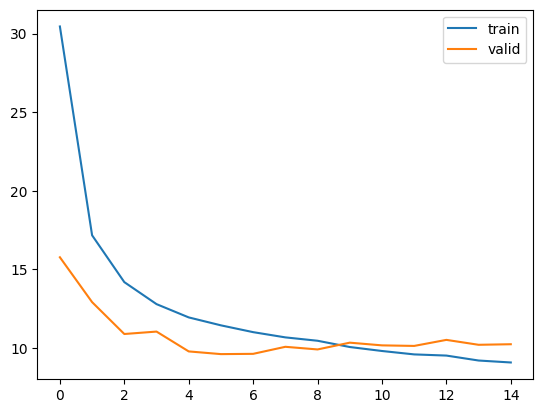

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = pf.metrics.quantile.QuantileLoss()

def train(epoch, val_mean_loss):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        x, y = data
        x = {key:val.to(device) for key, val in x.items()}
        
        # Train
        optimizer.zero_grad()
        pred = model(x).prediction
        loss = loss_fn(pred, y[0].to(device))
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_mean_loss}", end="")

    return mean_loss

def val():
    model.eval()
    total_len = len(val_dataloader)
    total_loss = 0
    for n, data in enumerate(val_dataloader):
        x, y = data
        x = {key:val.to(device) for key, val in x.items()}
        
        # Pred
        with torch.no_grad():
            pred = model(x).prediction
            loss = loss_fn(pred, y[0].to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
    return mean_loss
 
def plot(train_loss_li, val_loss_li):
    # Plot loss
    clear_output(wait=True)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.legend()
    plt.show()   

epoch = 15
train_loss_li, val_loss_li = [], []
val_mean_loss = 0
for e in range(epoch):
    train_loss = train(e, val_mean_loss) # Train
    val_mean_loss = val_loss = val()

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    plot(train_loss_li, val_loss_li)

# Eval

torch.Size([64, 9, 11])
torch.Size([64, 3])


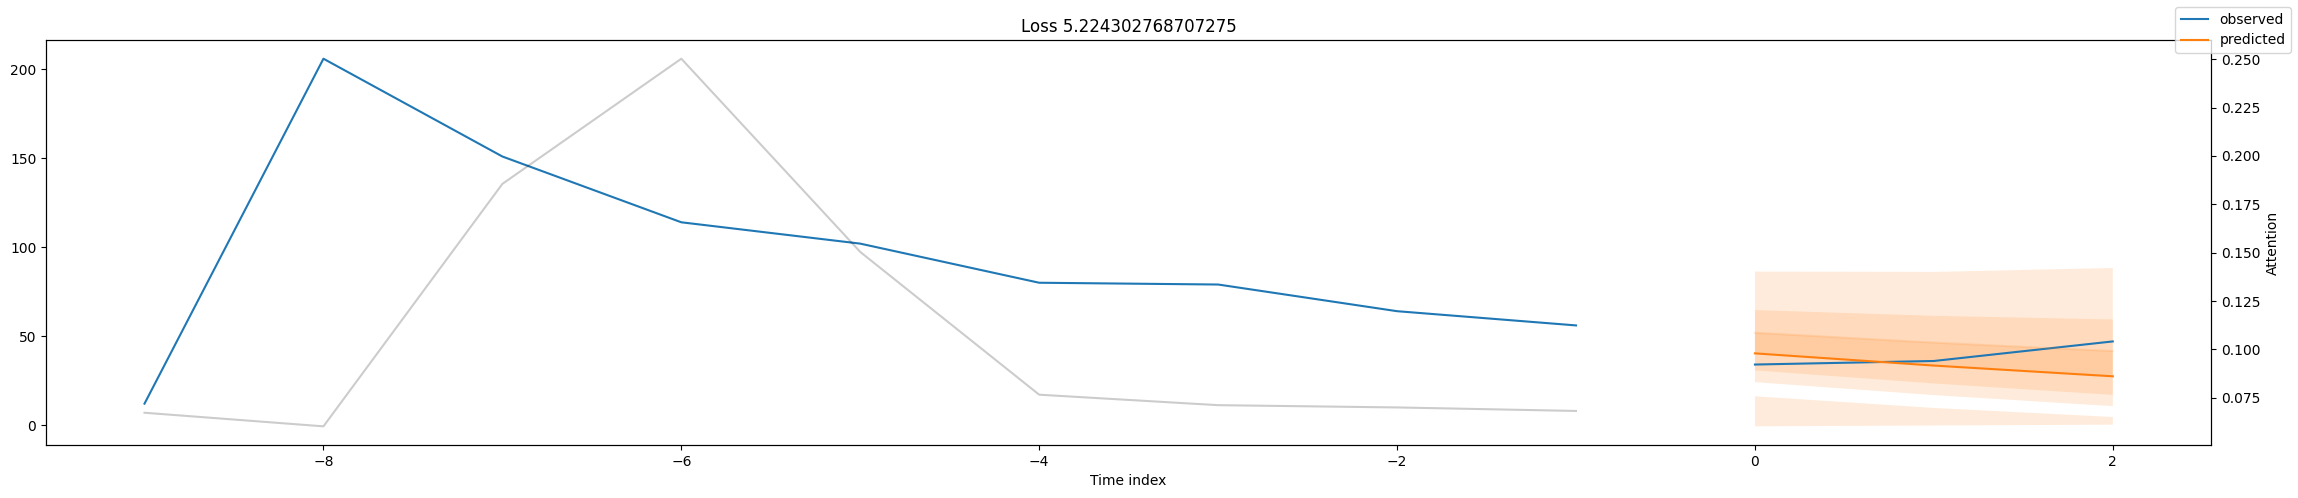

In [12]:
for data in val_dataloader:
    x, y = data
    x = {k:v.to(device) for k, v in x.items()}
    pred = model(x)
    print(x["encoder_cont"].shape)
    print(y[0].shape)

    fig, ax = plt.subplots(figsize=(23,5))
    model.plot_prediction(x, # network input
                        pred, # network output
                        idx=0,
                        add_loss_to_title=True,
                        ax=ax)
    break

In [14]:
model.

TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'sales', 'group_ids': ['img_path'], 'weight': None, 'max_encoder_length': 9, 'min_encoder_length': 4, 'min_prediction_idx': 0, 'min_prediction_length': 3, 'max_prediction_length': 3, 'static_categoricals': ['season', 'category', 'color', 'fabric', 'extra'], 'static_reals': ['img_path', 'release_day', 'release_week', 'release_month', 'release_year', 'encoder_length', 'sales_center', 'sales_scale'], 'time_varying_known_categoricals': [], 'time_varying_known_reals': ['time_idx', 'relative_time_idx'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['sales'], 'variable_groups': {}, 'constant_fill_strategy': {}, 'allow_missing_timesteps': False, 'lags': {}, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True